In [90]:
import torch, torchvision
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
from torchvision.models import vgg11
import numpy as np
from torch.nn import functional as F
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import backpack
from torch.nn import CrossEntropyLoss, Linear
#from utils import load_mnist_data
from mpl_toolkits.axes_grid1 import AxesGrid
from backpack import extend, backpack
from backpack.extensions import KFAC, DiagHessian
import argparse
import math
from scipy.stats import pearsonr
s=14
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#plt stuff
plt.rcParams["figure.figsize"] = (20,10)


# Data wrangling

In [91]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

transform_base = [transforms.ToTensor()]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    ] + transform_base)

transform_test = transforms.Compose(transform_base)
transform_train = transforms.RandomChoice([transform_train, transform_test])

#~/data/cifar10
CIFAR10_trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_trainset, batch_size=BATCH_SIZE_TRAIN_CIFAR10, shuffle=True, num_workers=2)

#~/data/cifar10
CIFAR10_testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_testset, batch_size=BATCH_SIZE_TEST_CIFAR10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


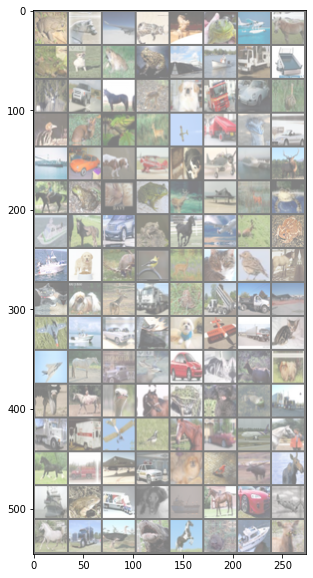

 frog horse plane   cat


In [92]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# VGG Network

In [93]:
def init2(model):
    for m in model.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

In [94]:
def vggNet():
    layers = nn.Sequential()
    layers.add_module('0', nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('1', nn.ReLU())
    layers.add_module('2', nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
    layers.add_module('3', nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('4', nn.ReLU())
    layers.add_module('5', nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
    layers.add_module('6', nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('7', nn.ReLU())
    layers.add_module('8', nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('9', nn.ReLU())
    layers.add_module('10', nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
    layers.add_module('11', nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('12', nn.ReLU())
    layers.add_module('13', nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('14', nn.ReLU())
    layers.add_module('15', nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
    layers.add_module('16', nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('17', nn.ReLU())
    layers.add_module('18', nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('19', nn.ReLU())
    layers.add_module('20', nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
    #layers.add_module('21', nn.AdaptiveAvgPool2d(output_size=(7, 7)))
    layers.add_module('21', nn.Flatten())
    layers.add_module('22', nn.Dropout(p=0.5, inplace=False))
    layers.add_module('23', nn.Linear(in_features=512, out_features=512, bias=True))
    layers.add_module('24', nn.ReLU())
    layers.add_module('25', nn.Dropout(p=0.5, inplace=False))
    layers.add_module('26', nn.Linear(in_features=512, out_features=512, bias=True))
    layers.add_module('27', nn.ReLU())
    layers.add_module('28', nn.Linear(in_features=512, out_features=10, bias=True))
    return layers

### training method

In [95]:
def train(net, epoch, optimizer, trainloader, filename):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print("train loss: ", train_loss)
    print("train accuracy: ", correct / total)
    print("saving model at: {}".format(filename))
    torch.save(net.state_dict(), filename)


def test(net, epoch, testloader, path, save=False):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        acc = correct / total
        if acc > best_acc and save:
            best_acc = acc
            print("saving model at: {}".format(path))
            torch.save(net.state_dict(), path)

        print("test loss: ", test_loss)
        print("current acc: {}; best acc: {}".format(acc, best_acc))


def train_all():
    CIFAR10_path = './checkpoint/ckpt_seed{}.pth'.format(s)
    CIFAR10_path_best = './checkpoint/best_ckpt_seed{}.pth'.format(s)
    lr = 0.001
    epoch = 0
    for e in [60, 40, 40]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(CIFAR10_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(CIFAR10_model, epoch, optimizer, CIFAR10_train_loader, CIFAR10_path)
            test(CIFAR10_model, epoch, CIFAR10_test_loader, save=True, path=CIFAR10_path_best)
            epoch += 1
        lr /= 10
        #lr *= 10
#train_all()

In [96]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda_status = torch.cuda.is_available()
CIFAR10_model = vggNet()#.to(device)
#init2(CIFAR10_model)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(CIFAR10_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

VGG_PATH = "../VGGtrained_weights/CIFAR10/CIFAR10_weights_seed={}.pth".format(s)

In [97]:
state = torch.load('./trained_weights/ckpt_seed{}.pth'.format(s), map_location=torch.device('cpu'))
CIFAR10_model.load_state_dict(state)
CIFAR10_model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU()
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU()
  (18): Conv2d(512, 512, kernel_s

In [98]:
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()



In [99]:
#try to load pretrained weights into Sequential

CIFAR10_model.load_state_dict(state)
CIFAR10_model.eval()

acc = []

max_len = len(CIFAR10_test_loader)
for batch_idx, (x, y) in enumerate(CIFAR10_test_loader):
        output = CIFAR10_model(x)
        accuracy = get_accuracy(output, y)
        if batch_idx % 10 == 0:
            print(
                "Batch {}/{} \t".format(batch_idx, max_len) + 
                "Accuracy %.0f" % (accuracy * 100) + "%"
            )
        acc.append(accuracy)
    
avg_acc = np.mean(acc)
print('overall test accuracy on CIFAR10: {:.02f} %'.format(avg_acc * 100))

Batch 0/79 	Accuracy 95%
Batch 10/79 	Accuracy 93%
Batch 20/79 	Accuracy 94%
Batch 30/79 	Accuracy 91%
Batch 40/79 	Accuracy 88%
Batch 50/79 	Accuracy 93%
Batch 60/79 	Accuracy 86%
Batch 70/79 	Accuracy 90%
overall test accuracy on CIFAR10: 90.59 %


In [100]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = torch.nn.CrossEntropyLoss()
    model.train()
    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()

            model.zero_grad()
            loss = lossfunc(model(x), y)
            print(loss)
            loss.backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv

            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))

    return(Cov_diag)

In [101]:
#testHessian = get_Hessian_NN(CIFAR10_model, CIFAR10_train_loader, prec0=0.001)

In [102]:
Hessian = torch.load('./trained_weights/vggHessian_seed{}.pth'.format(s), map_location=torch.device('cpu'))

In [121]:
print(len(Hessian))

22


In [126]:
for i, tnsr in enumerate(Hessian):
    if i%2 == 0:
        print(torch.mean(tnsr))

tensor(59.1689)
tensor(84.3174)
tensor(81.7705)
tensor(85.1711)
tensor(90.0464)
tensor(95.9320)
tensor(99.1591)
tensor(99.6296)
tensor(97.6536)
tensor(98.3906)
tensor(84.0119)


In [104]:
for i, tnsr in enumerate(Hessian):
    if i%2 == 0:
        print(tnsr.size())

torch.Size([64, 3, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([256, 128, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([512, 256, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([10, 512])


In [105]:
for i, tnsr in enumerate(Hessian):
    if i%2 == 0:
        print(len(torch.flatten(tnsr).detach().numpy()))#, bins='auto', edgecolor='black', alpha=.5, density=True)
        

1728
73728
294912
589824
1179648
2359296
2359296
2359296
262144
262144
5120


In [122]:
for i, (name, param) in enumerate(CIFAR10_model.named_parameters()):
    #if i%2 == 0:
        print(name)
        #print(torch.mean(torch.flatten(param)))#.detach().numpy()))#, bins='auto', edgecolor='black', alpha=.5, density=True)
        #plt.show()

0.weight
0.bias
3.weight
3.bias
6.weight
6.bias
8.weight
8.bias
11.weight
11.bias
13.weight
13.bias
16.weight
16.bias
18.weight
18.bias
23.weight
23.bias
26.weight
26.bias
28.weight
28.bias


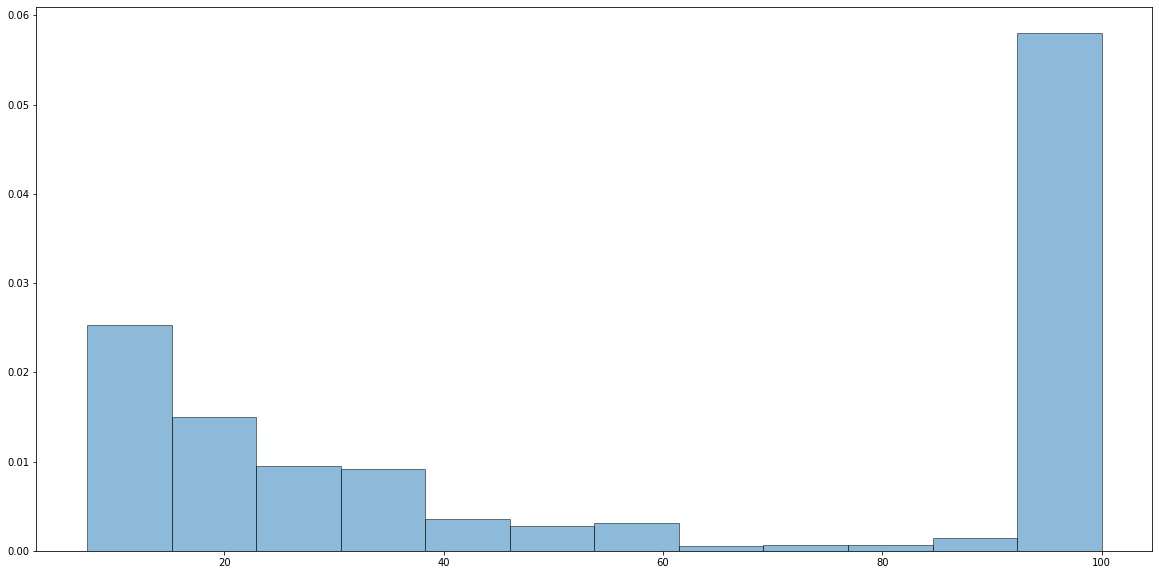

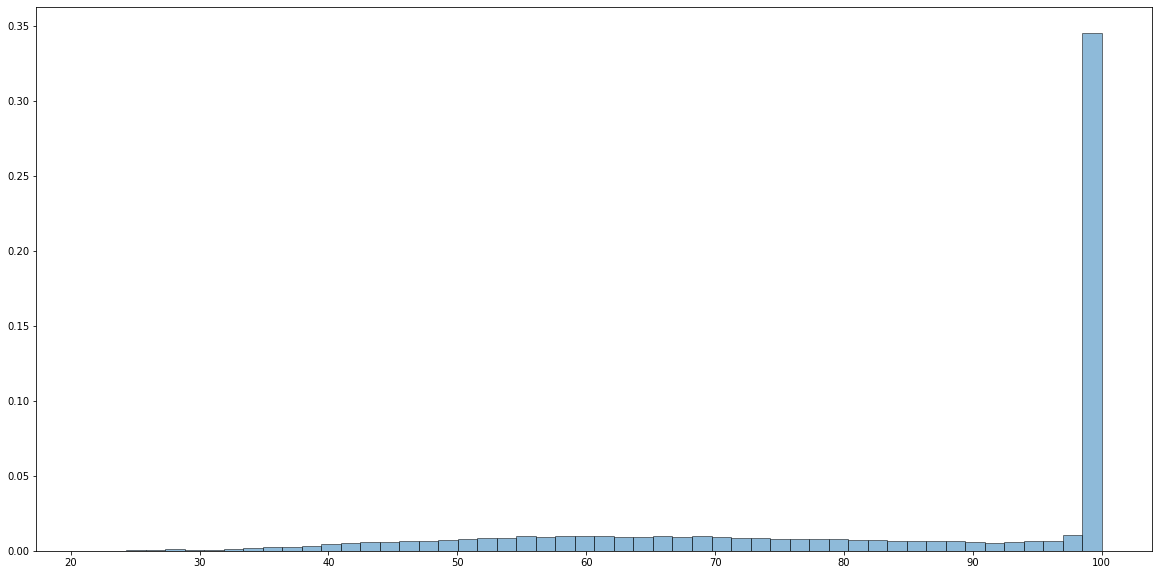

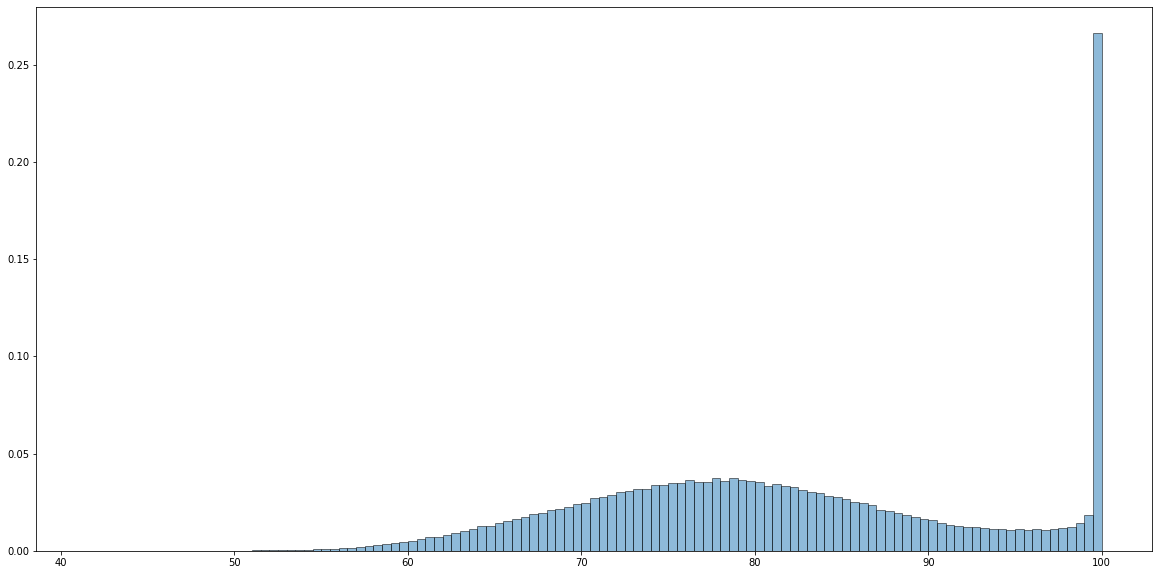

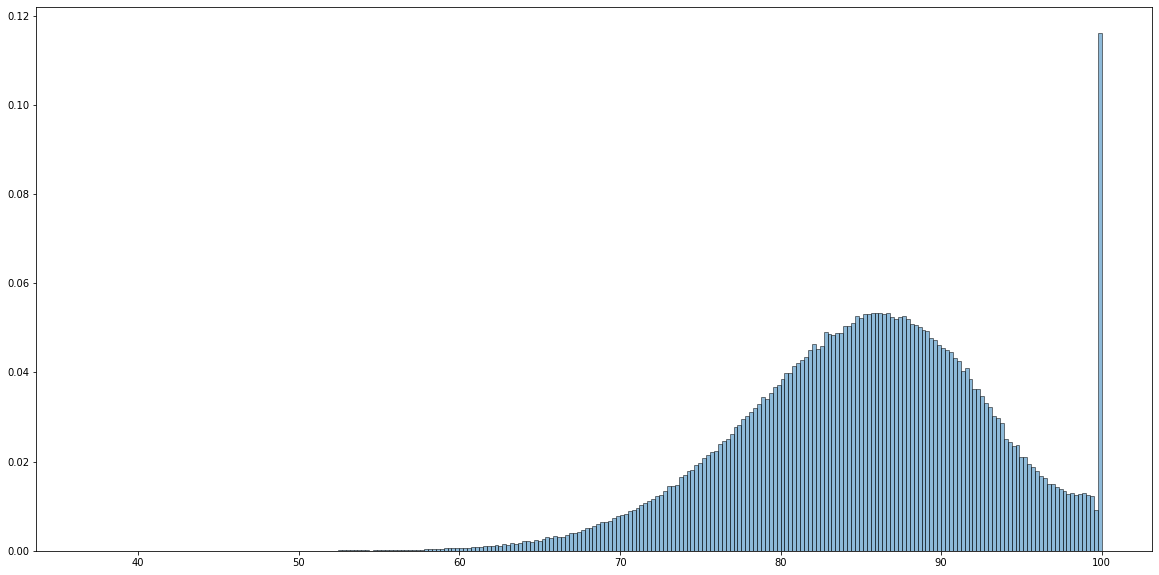

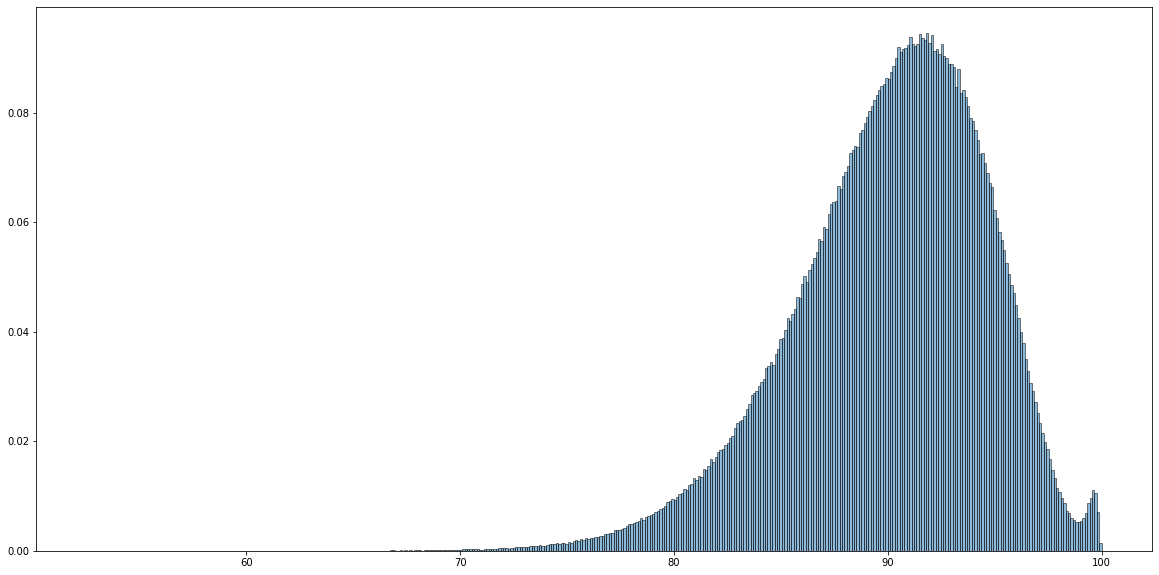

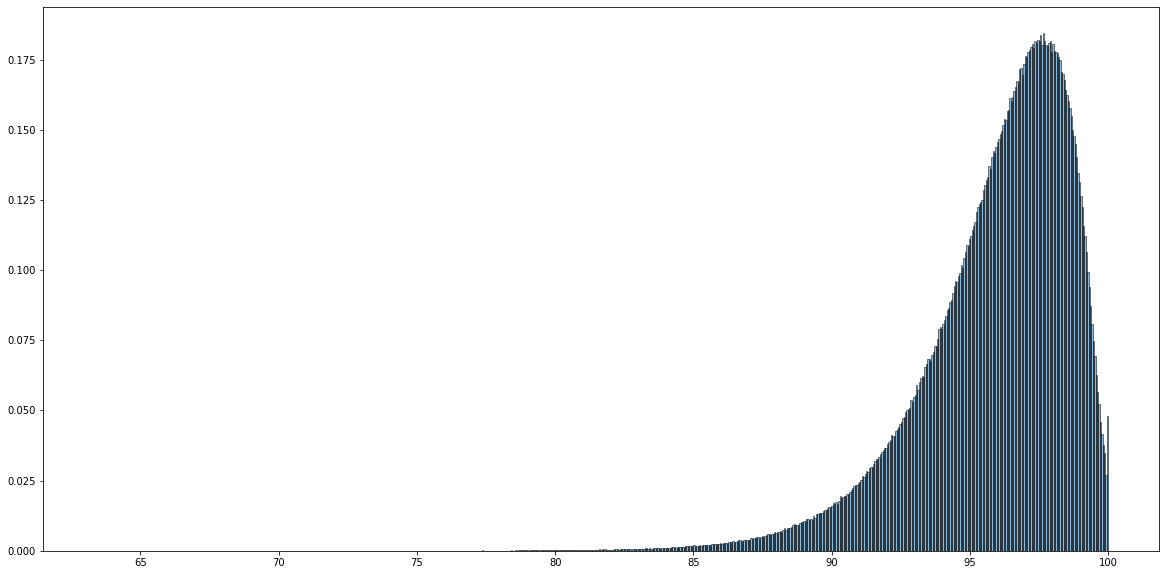

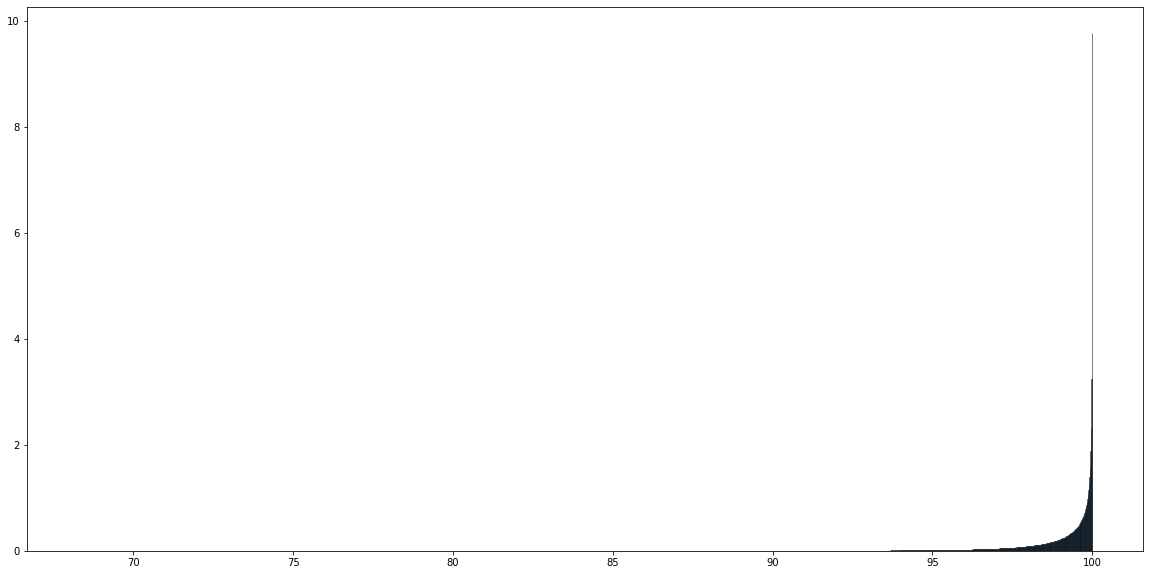

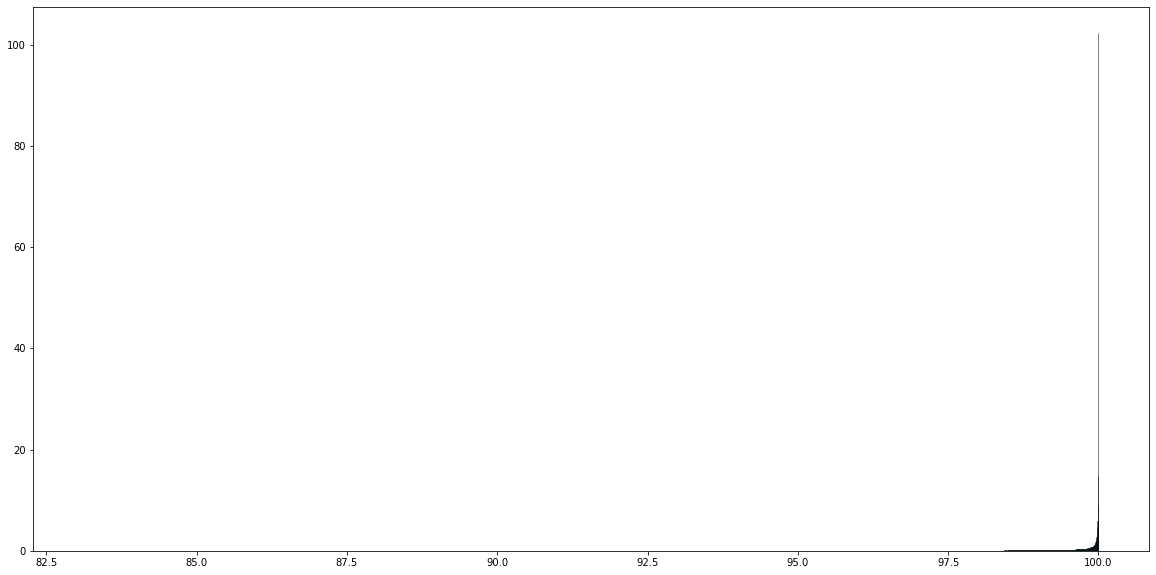

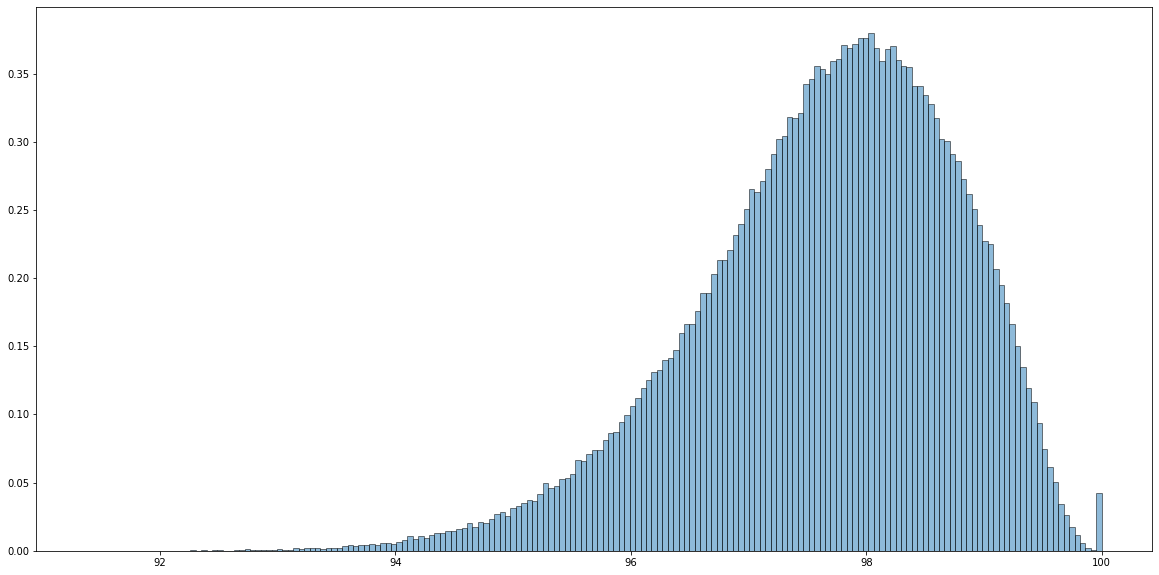

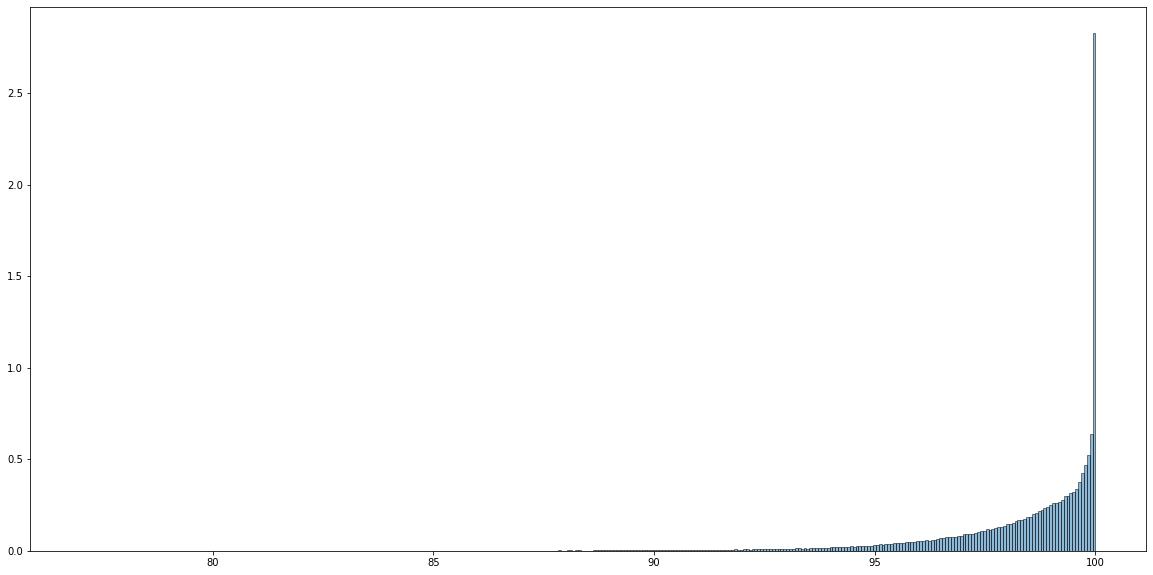

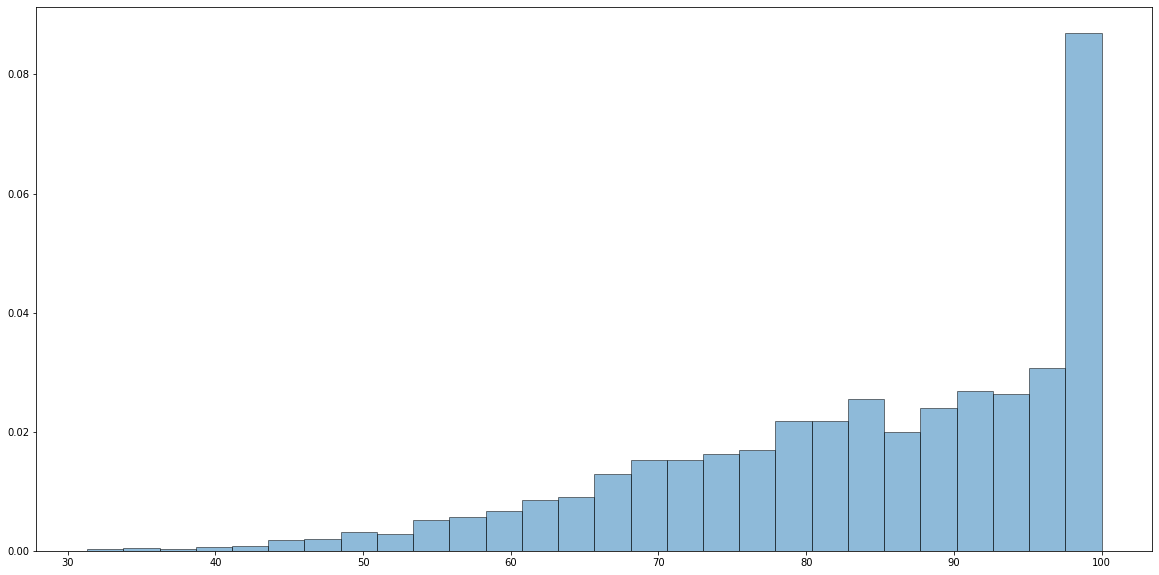

In [125]:
for i, tnsr in enumerate(Hessian):
    if i%2 == 0:
        plt.hist(torch.flatten(tnsr).detach().numpy(), bins='auto', edgecolor='black', alpha=.5, density=True)
        plt.show()

0.weight


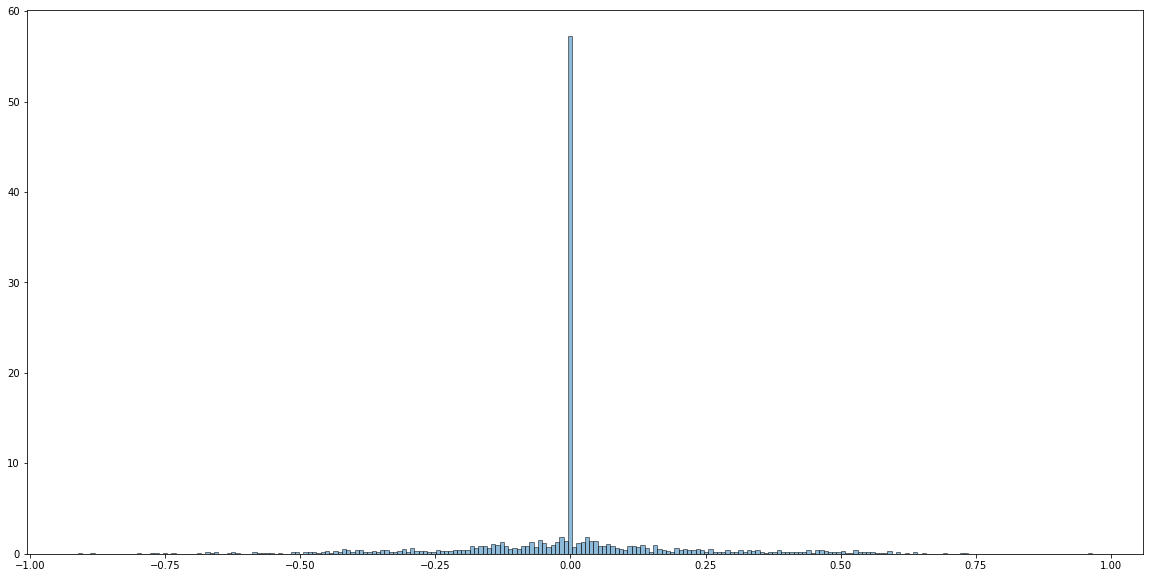

3.weight


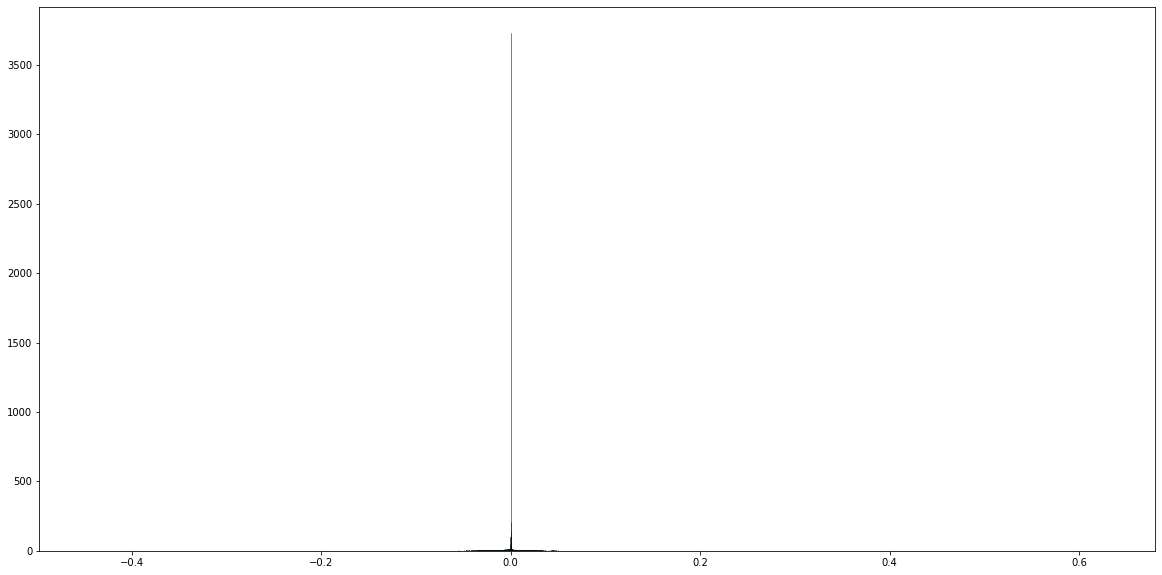

6.weight


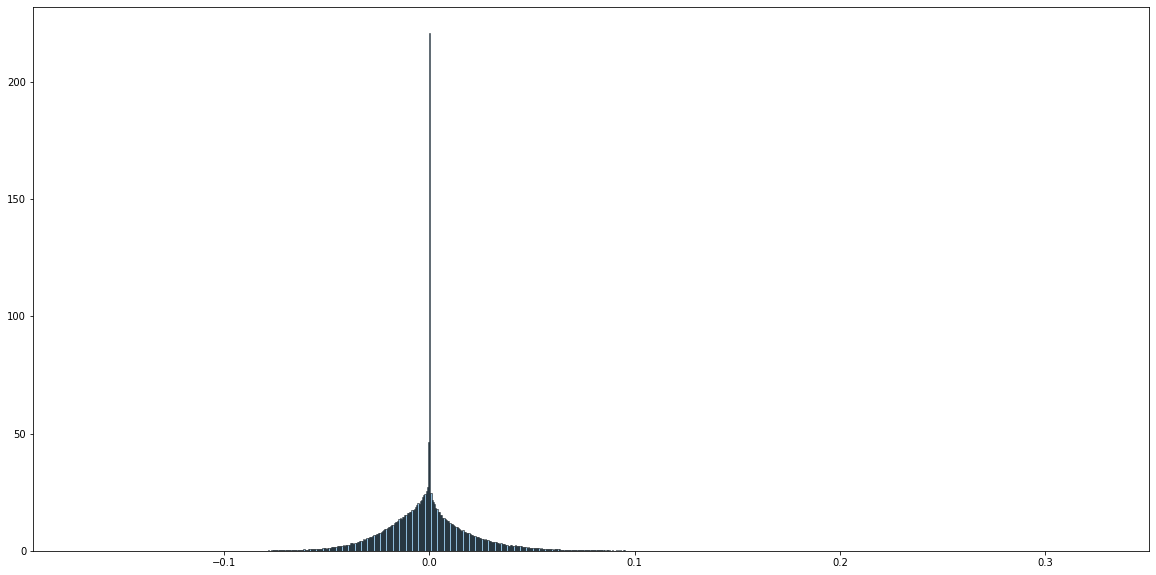

8.weight


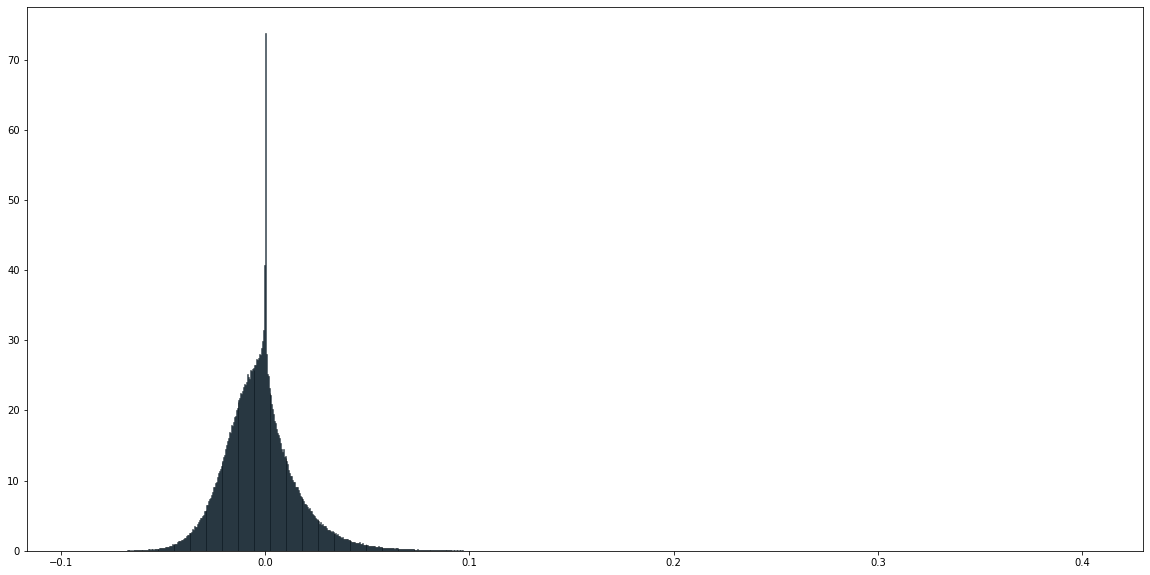

11.weight


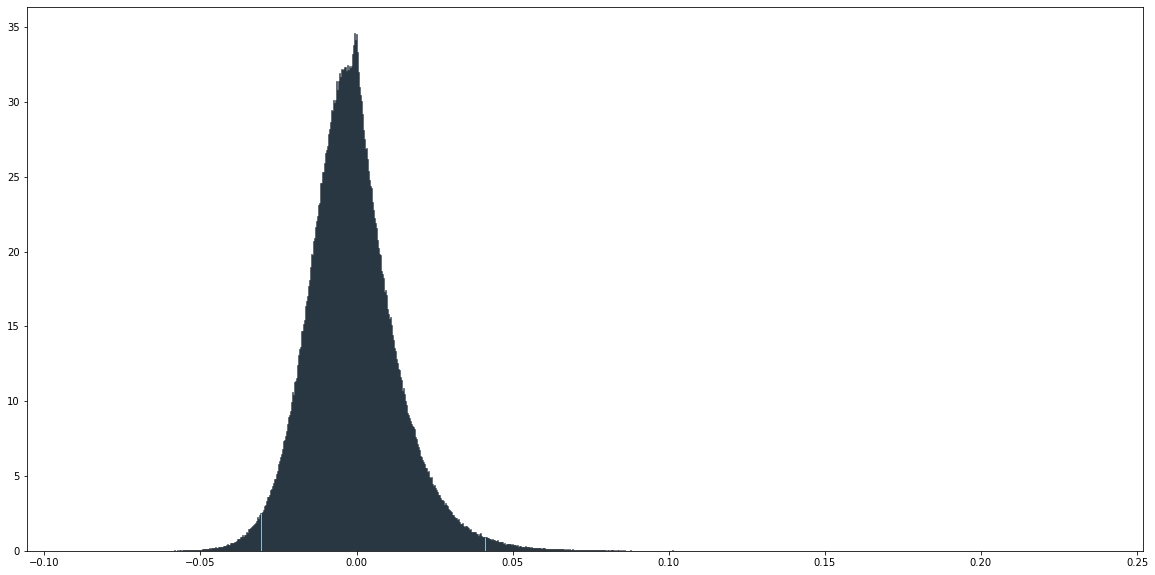

13.weight


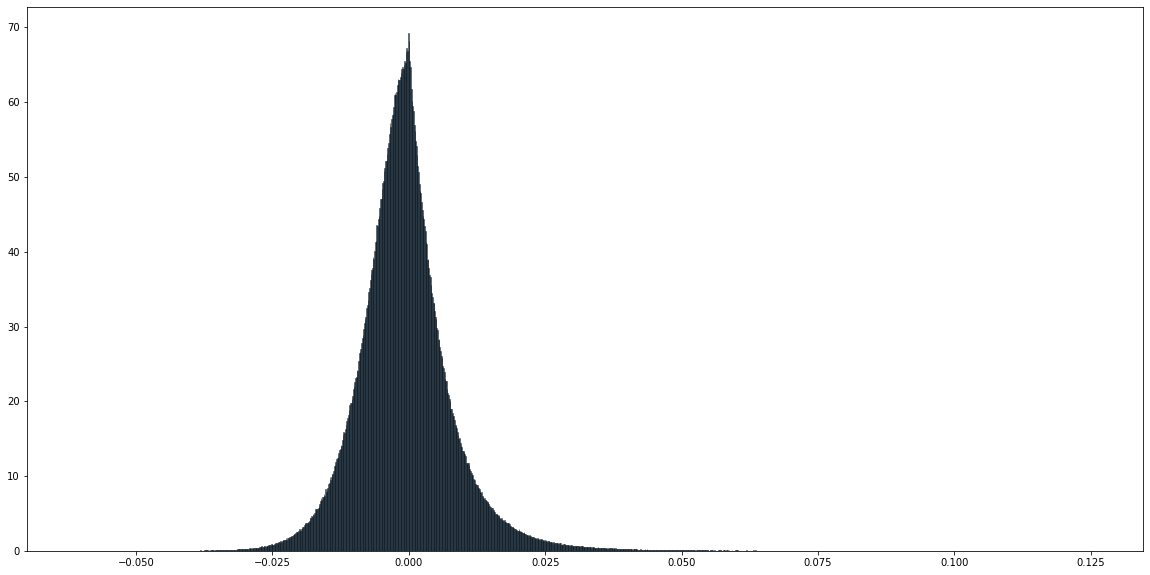

16.weight


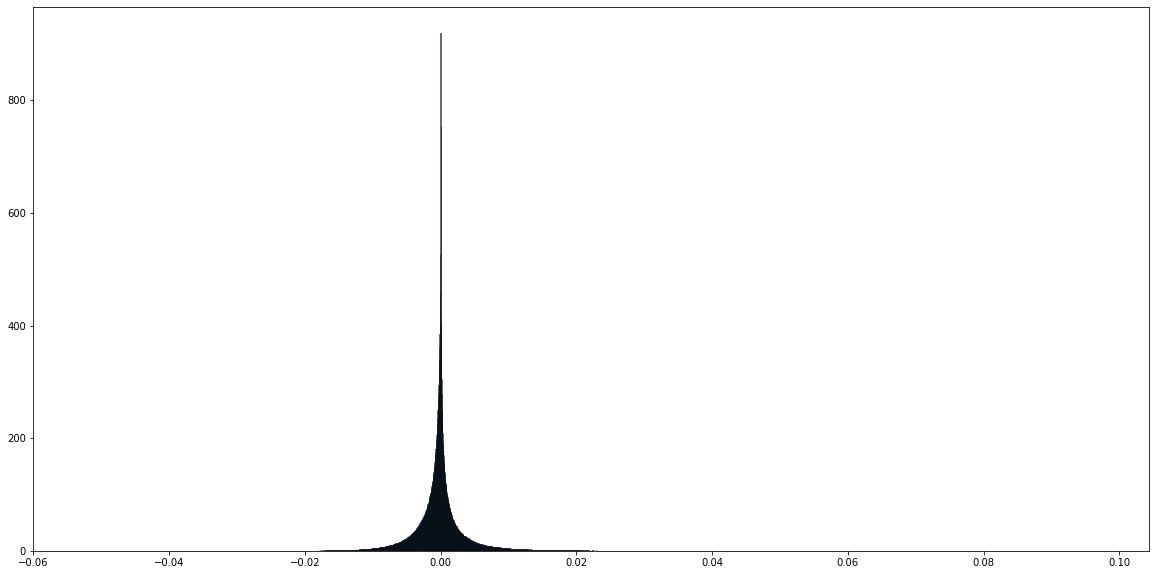

18.weight


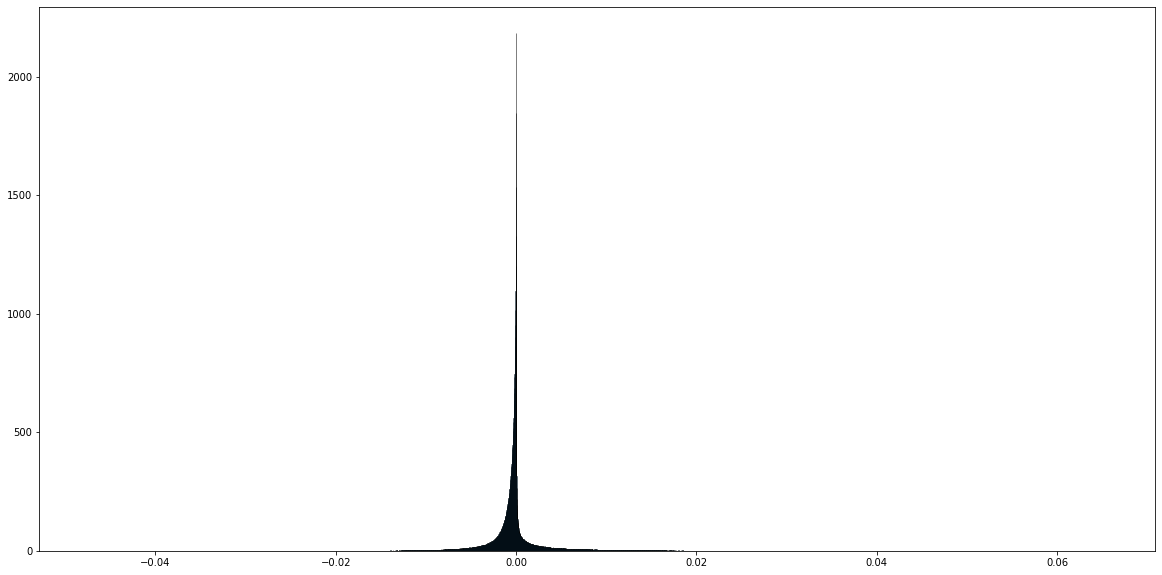

23.weight


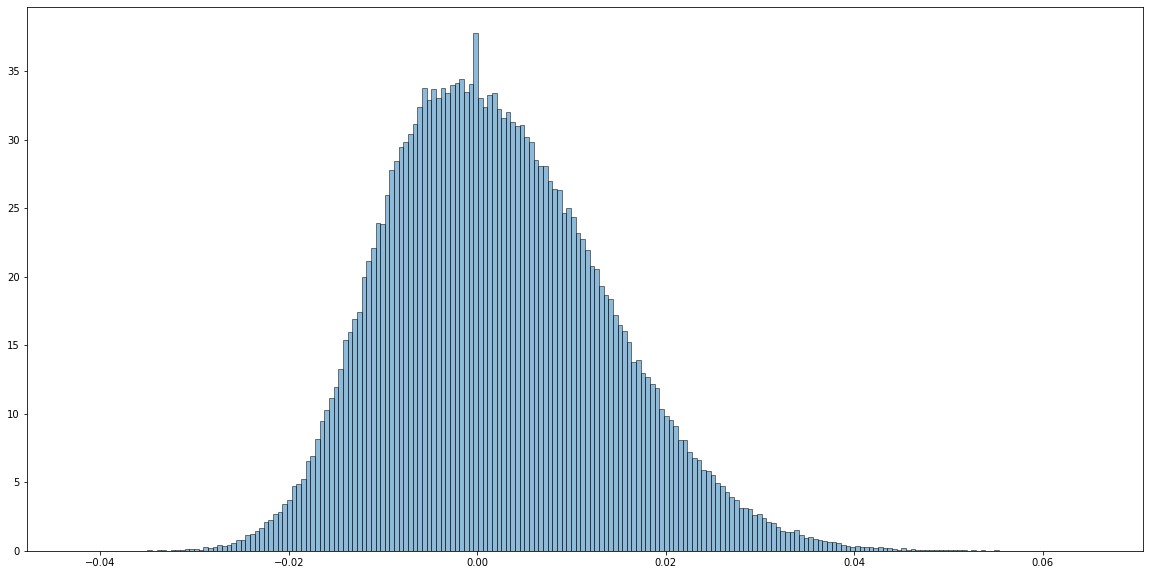

26.weight


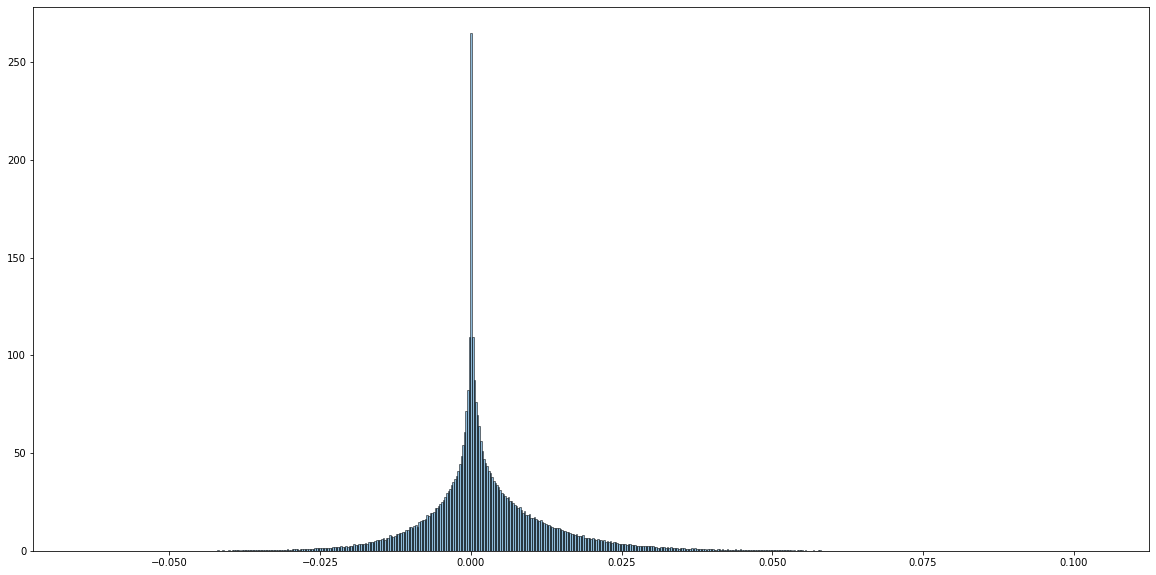

28.weight


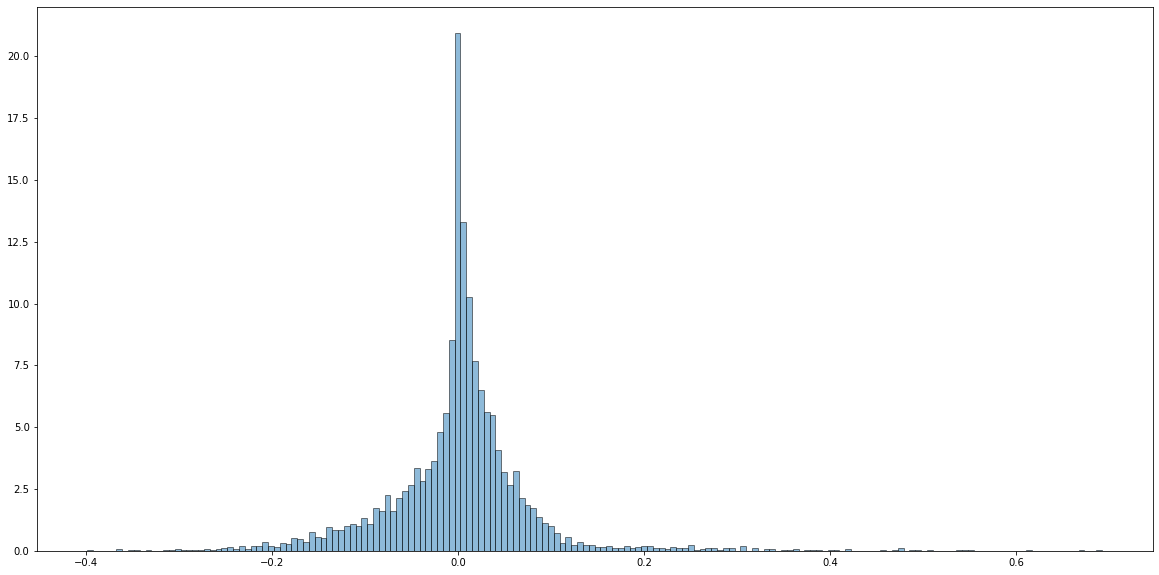

In [123]:
for i, (name, param) in enumerate(CIFAR10_model.named_parameters()):
    if i%2 == 0:
        print(name)
        plt.hist(torch.flatten(param).detach().numpy(), bins='auto', edgecolor='black', alpha=.5, density=True)
        plt.show()

layer index: 0
layer name: 0.weight
torch.Size([64, 3, 3, 3]) torch.Size([64, 3, 3, 3])

Pearsons correlation: -0.018


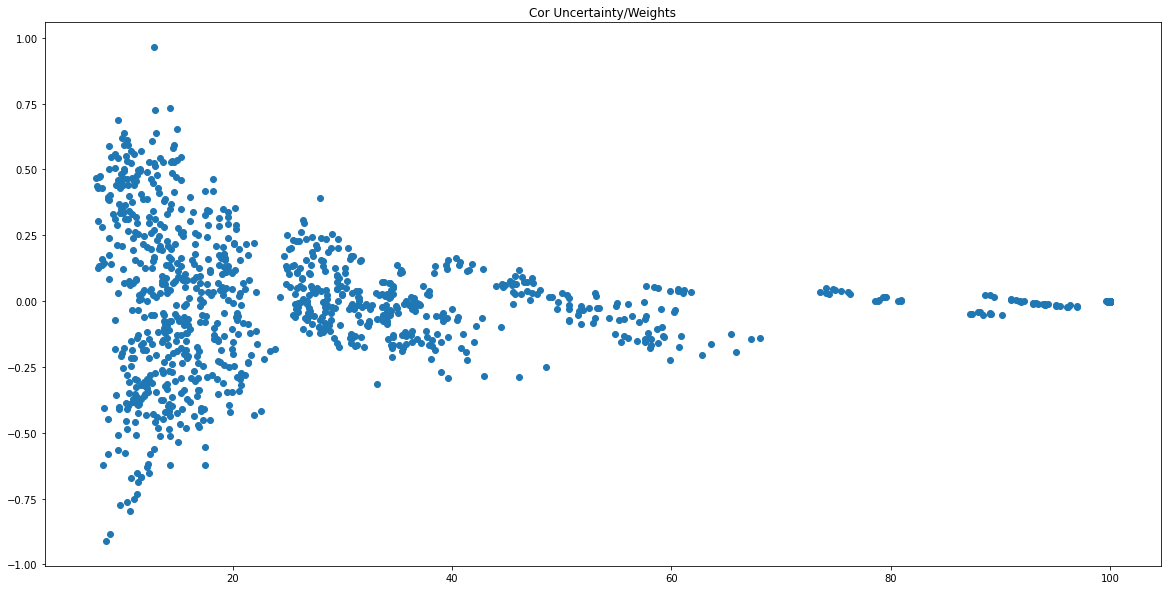

layer index: 1
layer name: 0.bias
torch.Size([64]) torch.Size([64])

Pearsons correlation: -0.147


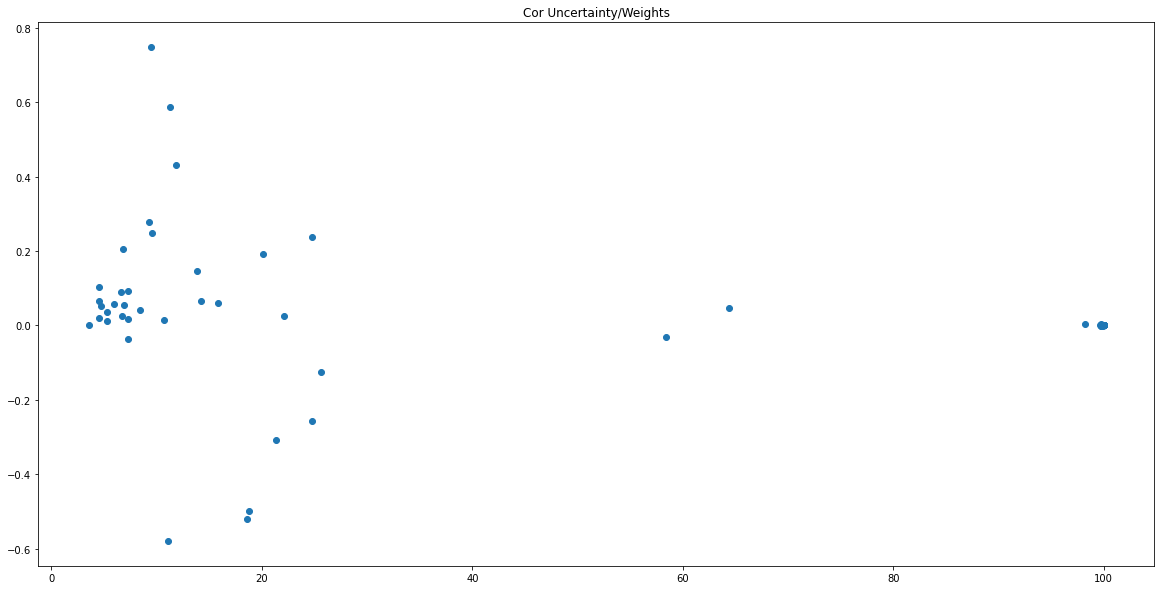

layer index: 2
layer name: 3.weight
torch.Size([128, 64, 3, 3]) torch.Size([128, 64, 3, 3])

Pearsons correlation: -0.086


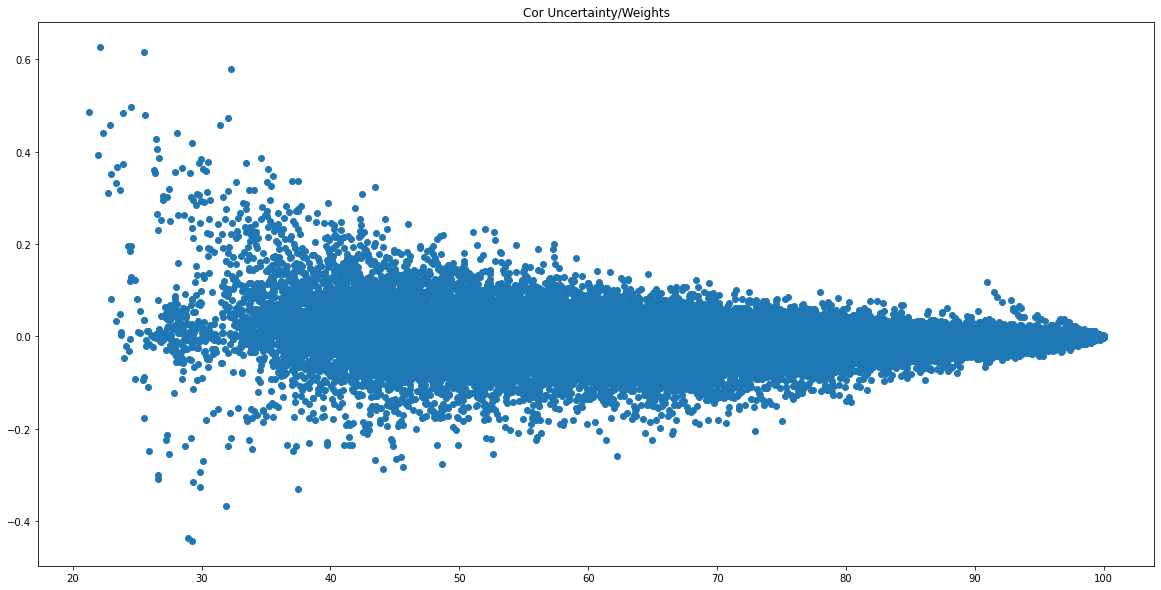

layer index: 3
layer name: 3.bias
torch.Size([128]) torch.Size([128])

Pearsons correlation: -0.039


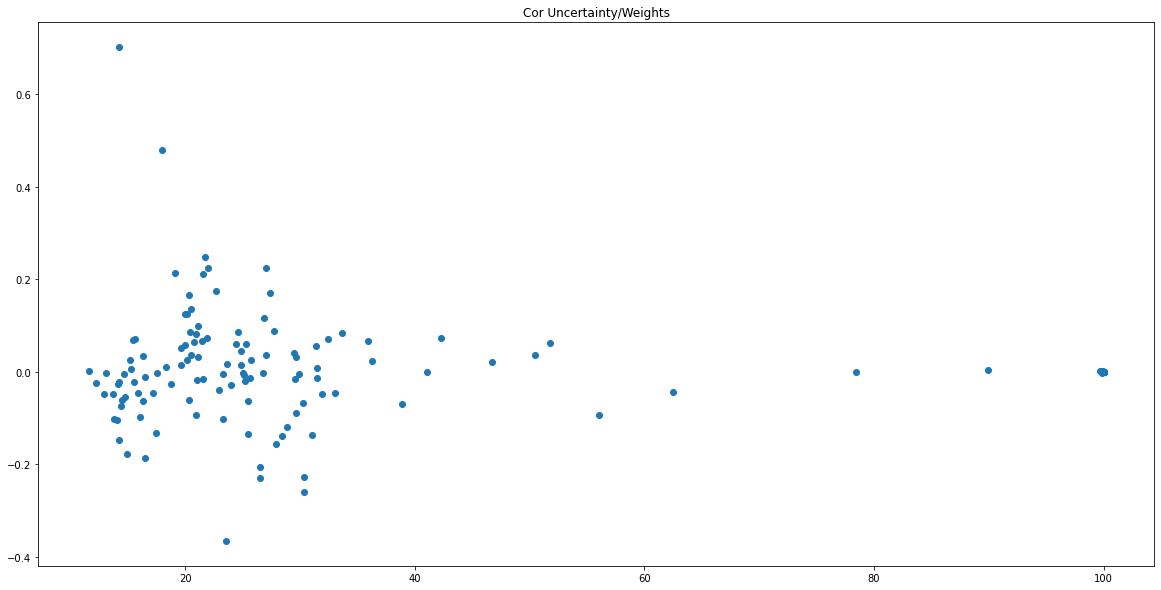

layer index: 4
layer name: 6.weight
torch.Size([256, 128, 3, 3]) torch.Size([256, 128, 3, 3])

Pearsons correlation: -0.164


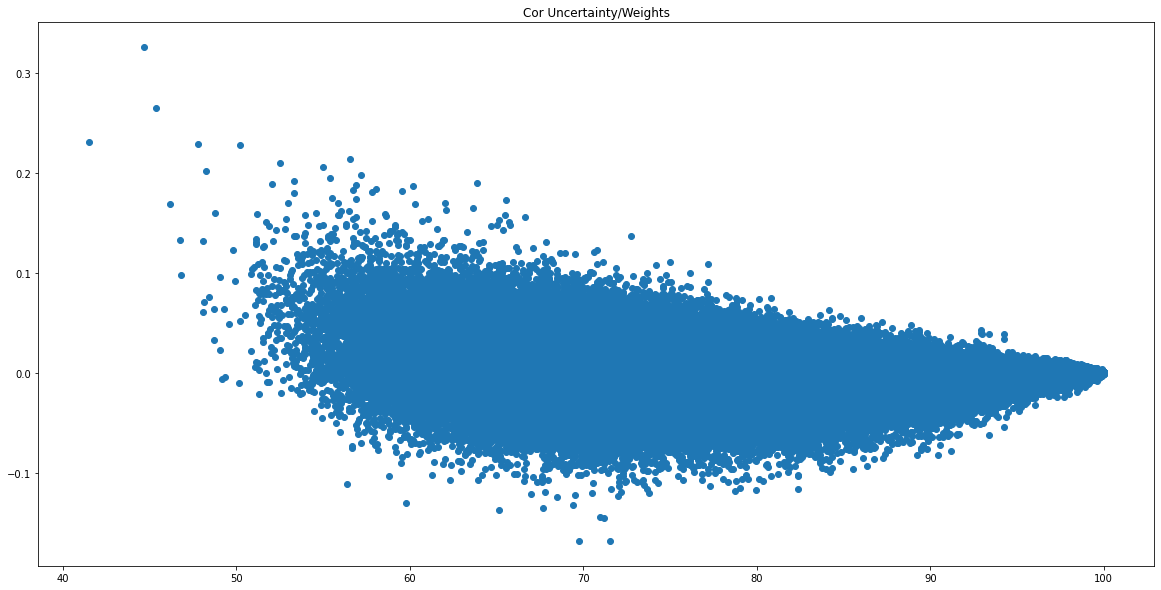

layer index: 5
layer name: 6.bias
torch.Size([256]) torch.Size([256])

Pearsons correlation: -0.275


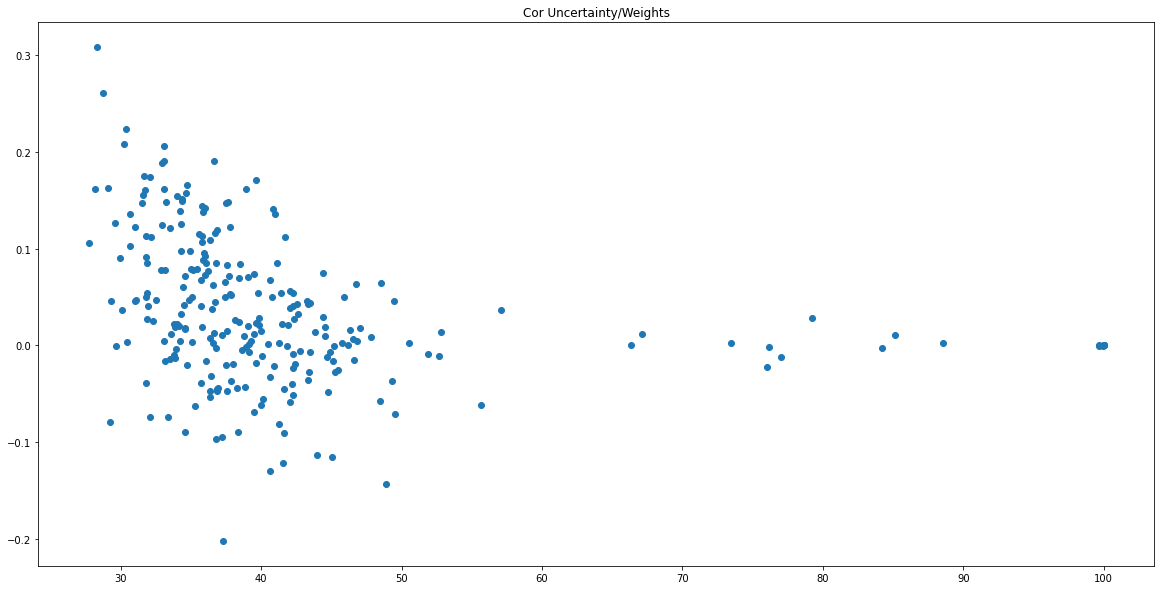

layer index: 6
layer name: 8.weight
torch.Size([256, 256, 3, 3]) torch.Size([256, 256, 3, 3])

Pearsons correlation: -0.326


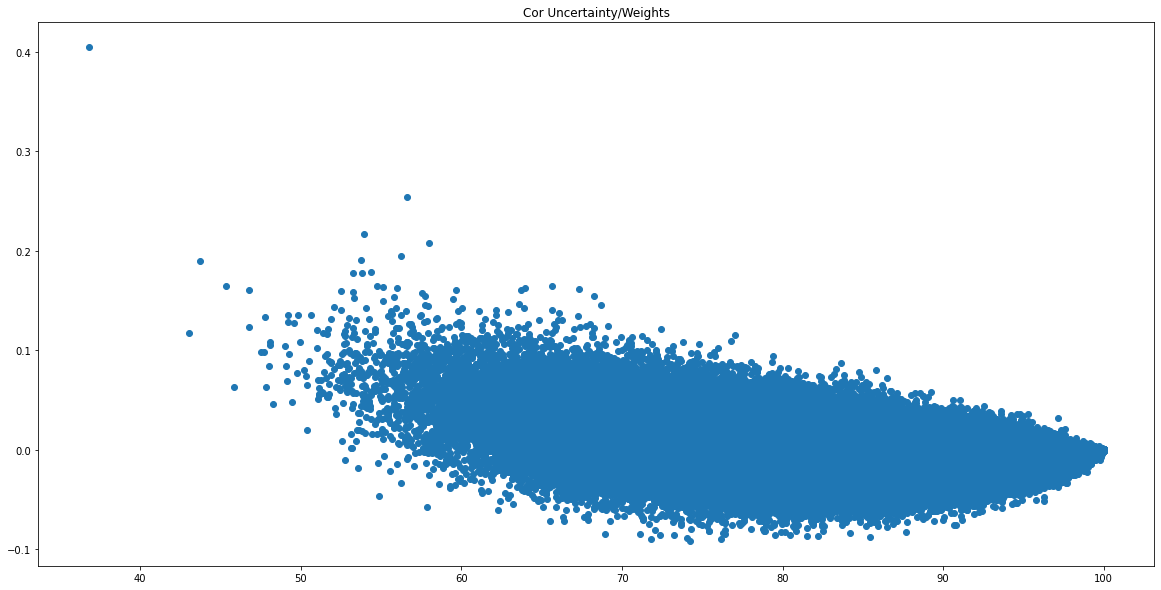

layer index: 7
layer name: 8.bias
torch.Size([256]) torch.Size([256])

Pearsons correlation: -0.322


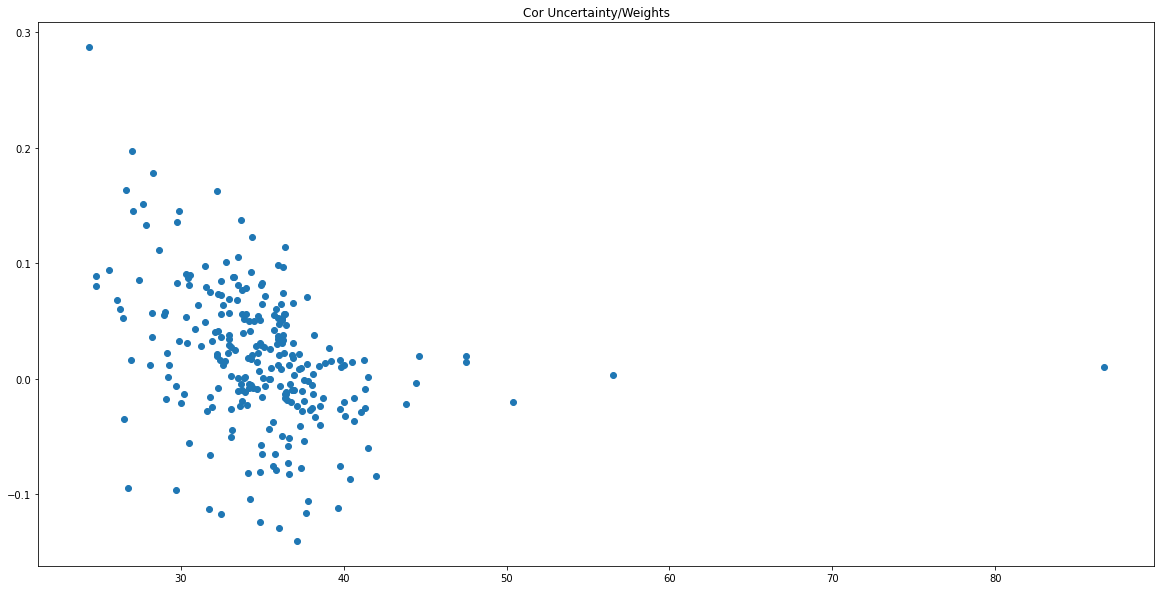

layer index: 8
layer name: 11.weight
torch.Size([512, 256, 3, 3]) torch.Size([512, 256, 3, 3])

Pearsons correlation: -0.322


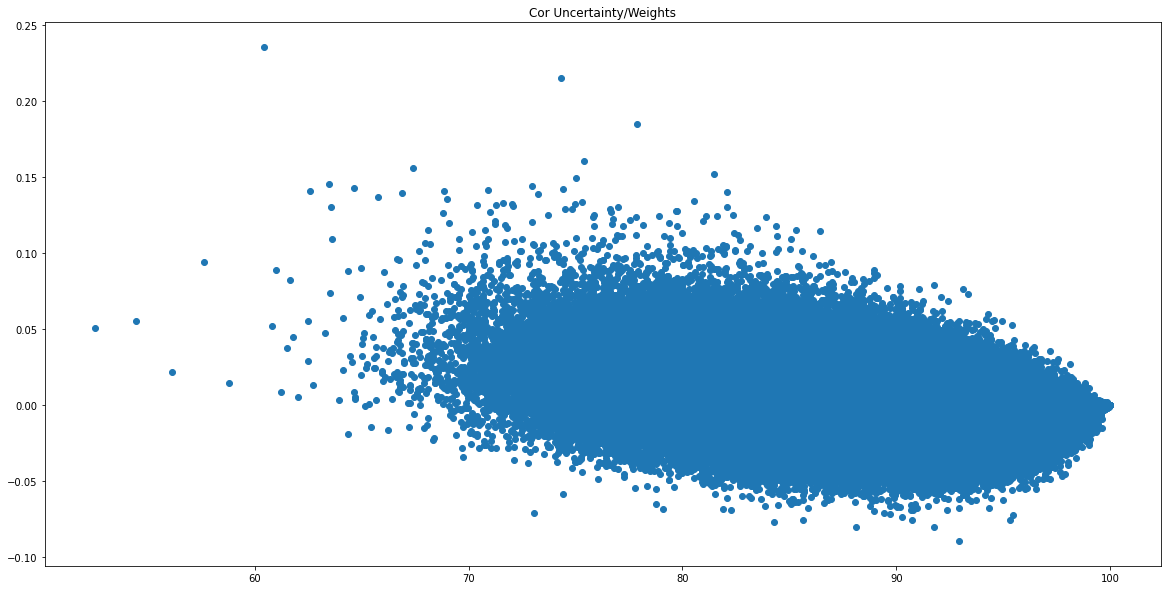

layer index: 9
layer name: 11.bias
torch.Size([512]) torch.Size([512])

Pearsons correlation: -0.212


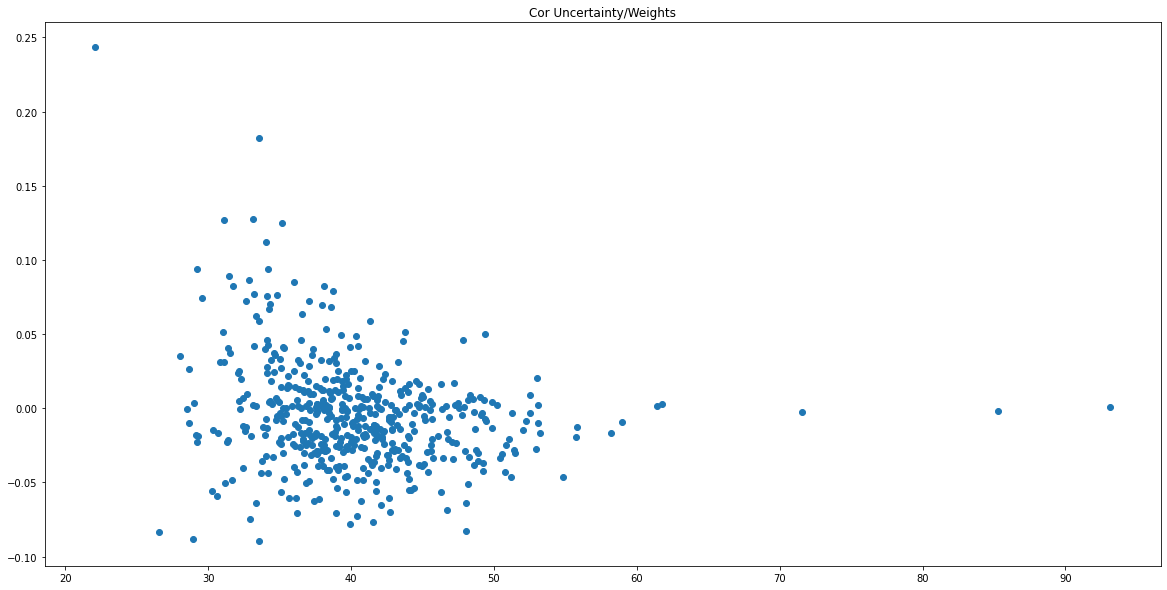

layer index: 10
layer name: 13.weight
torch.Size([512, 512, 3, 3]) torch.Size([512, 512, 3, 3])

Pearsons correlation: -0.227


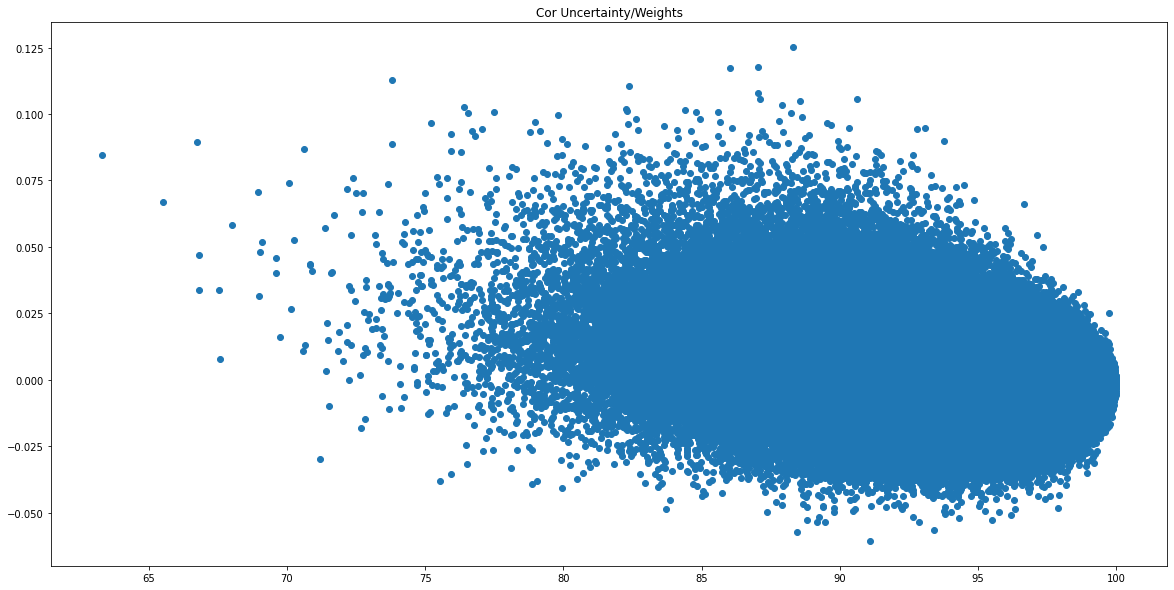

layer index: 11
layer name: 13.bias
torch.Size([512]) torch.Size([512])

Pearsons correlation: -0.380


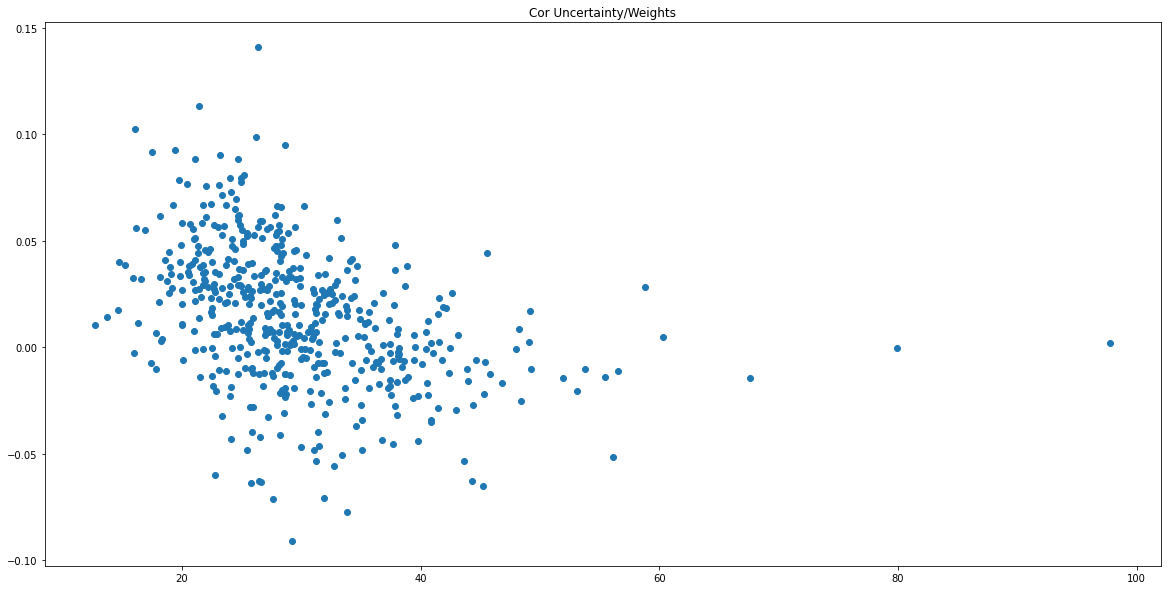

layer index: 12
layer name: 16.weight
torch.Size([512, 512, 3, 3]) torch.Size([512, 512, 3, 3])

Pearsons correlation: -0.134


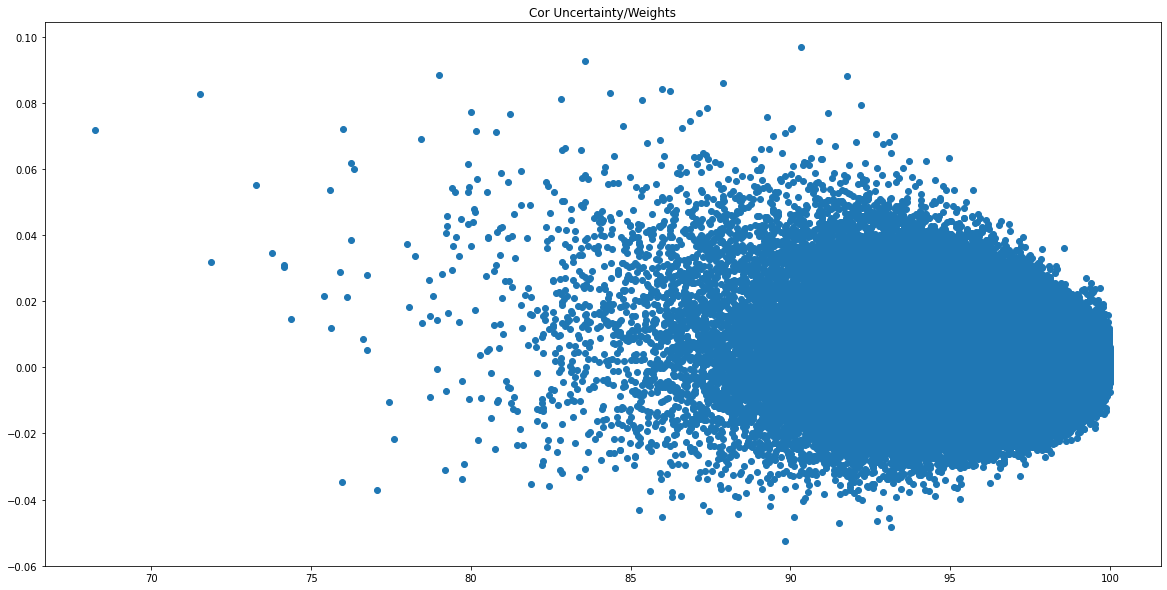

layer index: 13
layer name: 16.bias
torch.Size([512]) torch.Size([512])

Pearsons correlation: -0.541


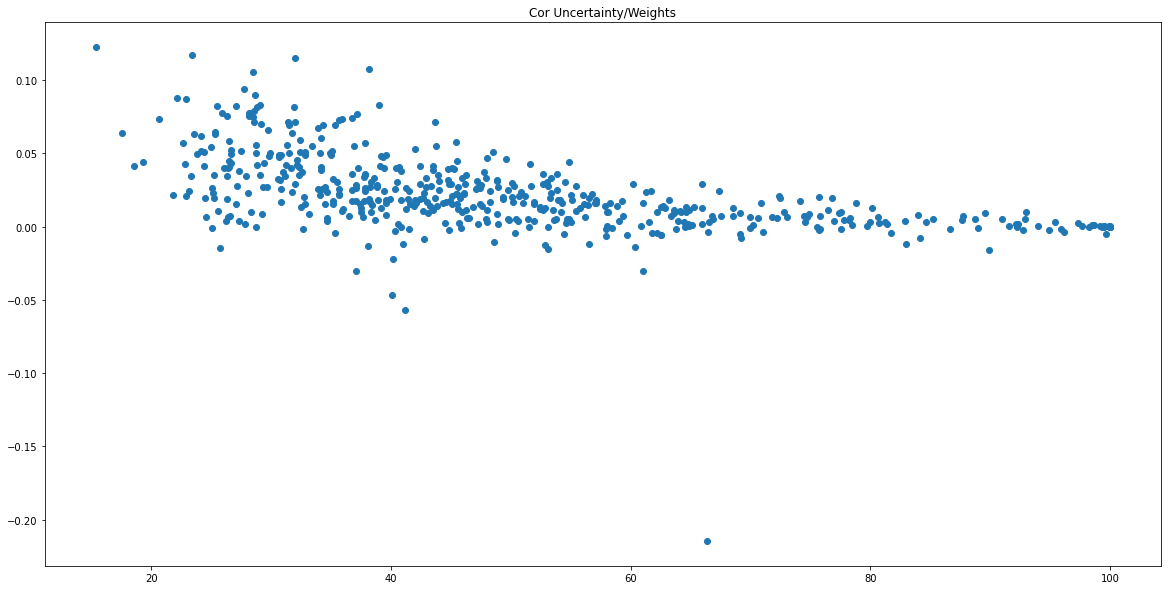

layer index: 14
layer name: 18.weight
torch.Size([512, 512, 3, 3]) torch.Size([512, 512, 3, 3])

Pearsons correlation: -0.271


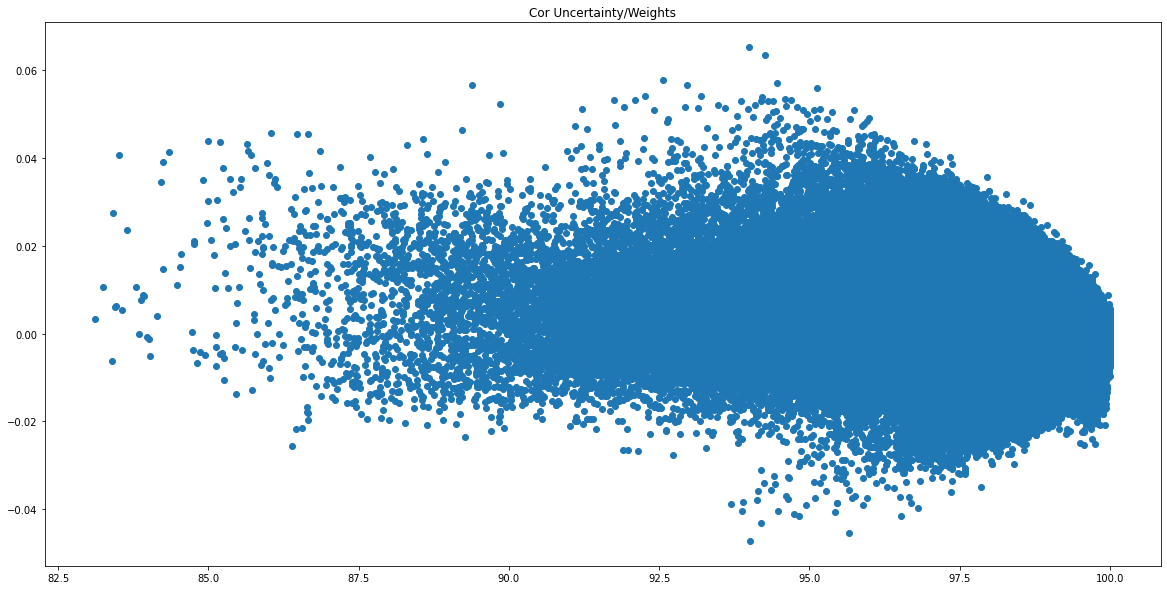

layer index: 15
layer name: 18.bias
torch.Size([512]) torch.Size([512])

Pearsons correlation: -0.527


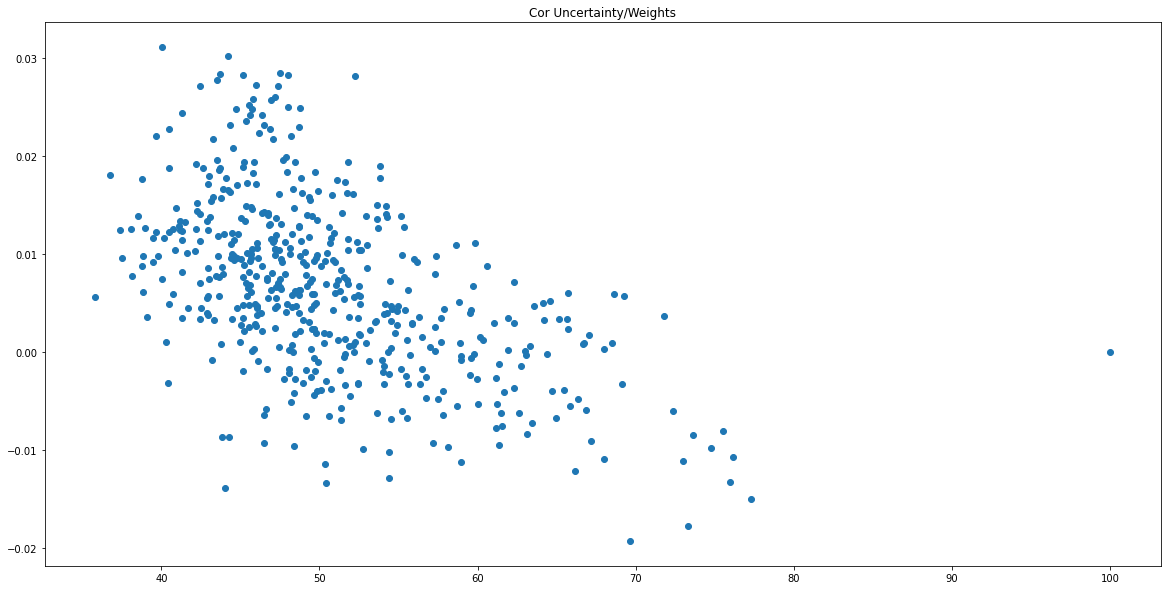

layer index: 16
layer name: 23.weight
torch.Size([512, 512]) torch.Size([512, 512])

Pearsons correlation: -0.258


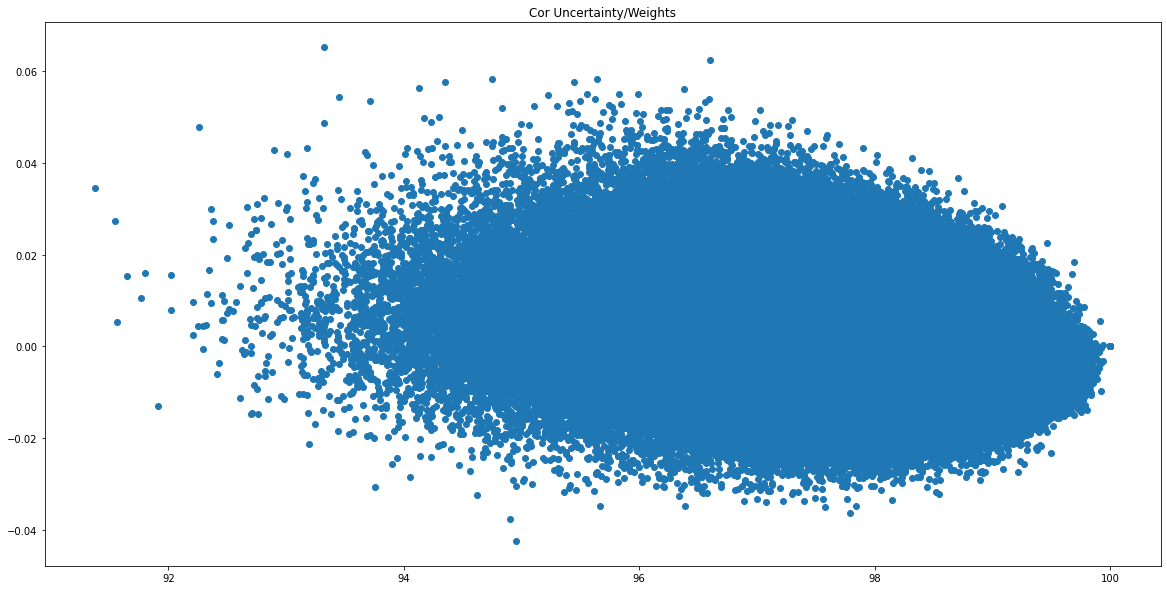

layer index: 17
layer name: 23.bias
torch.Size([512]) torch.Size([512])

Pearsons correlation: -0.368


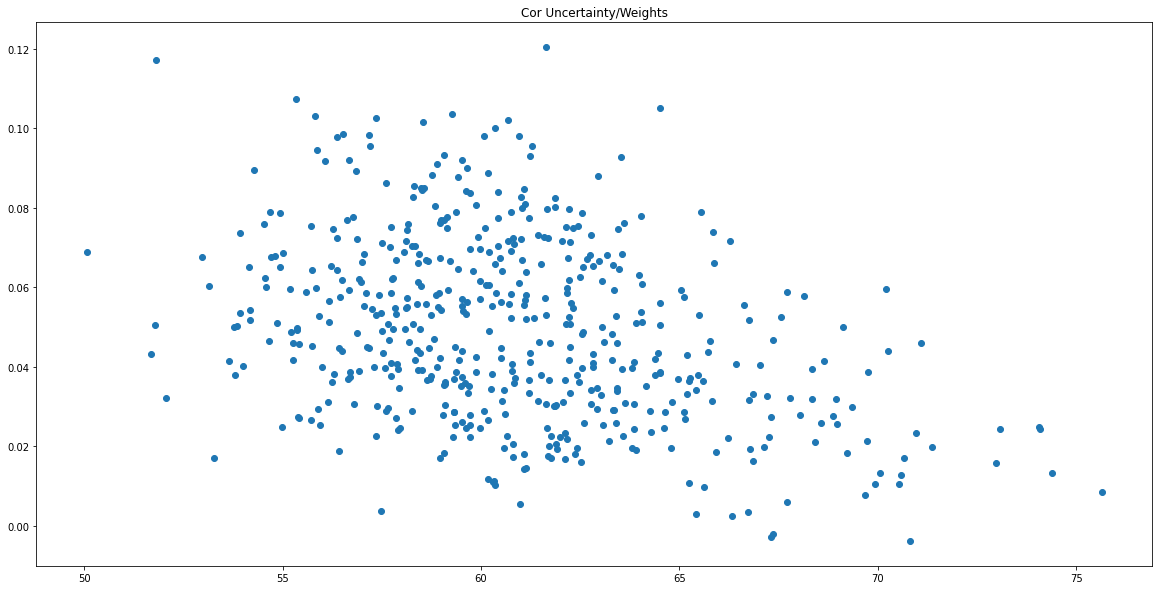

layer index: 18
layer name: 26.weight
torch.Size([512, 512]) torch.Size([512, 512])

Pearsons correlation: -0.269


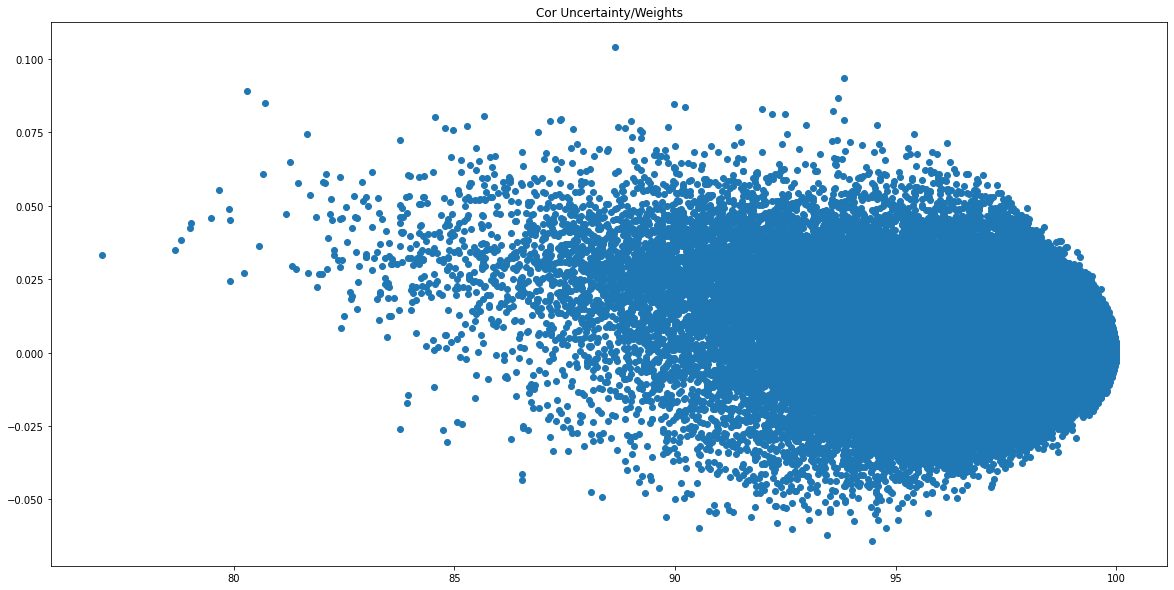

layer index: 19
layer name: 26.bias
torch.Size([512]) torch.Size([512])

Pearsons correlation: -0.870


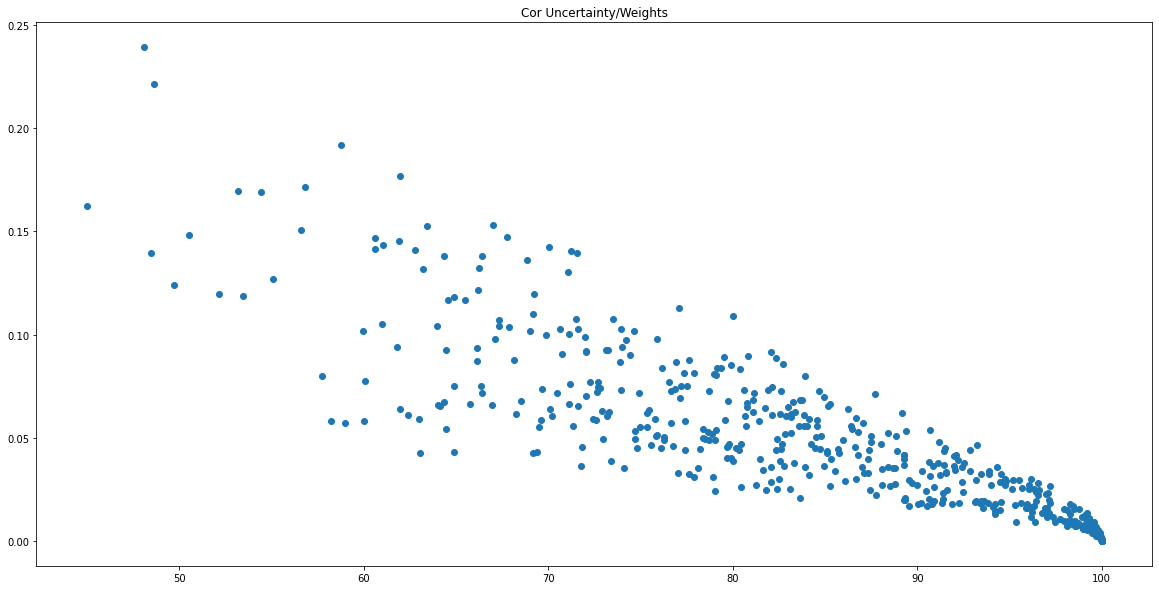

layer index: 20
layer name: 28.weight
torch.Size([10, 512]) torch.Size([10, 512])

Pearsons correlation: -0.369


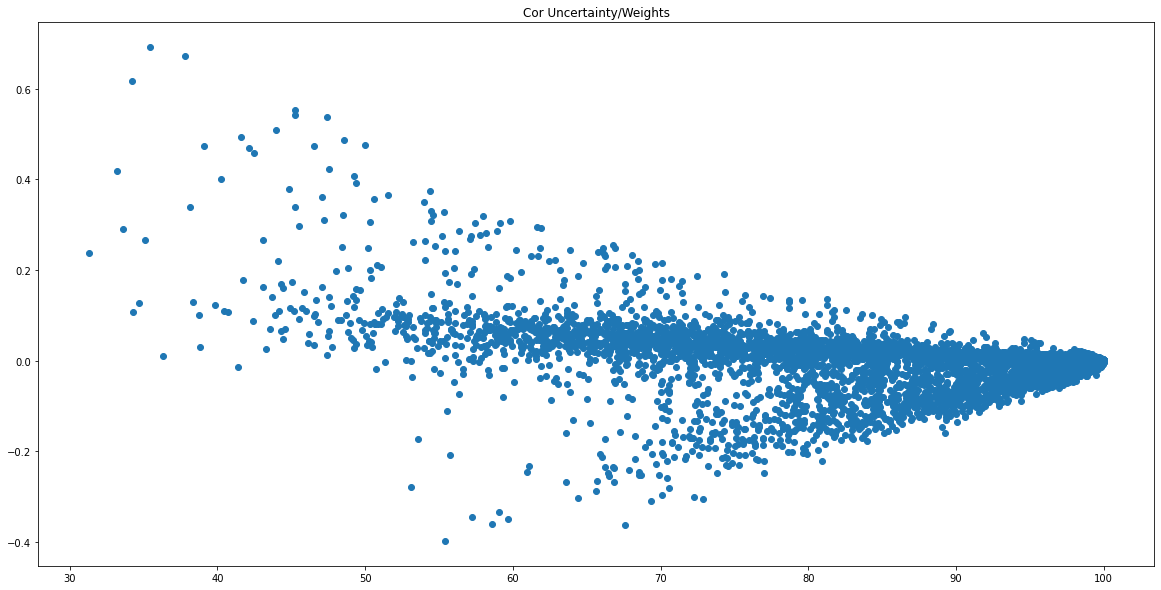

layer index: 21
layer name: 28.bias
torch.Size([10]) torch.Size([10])

Pearsons correlation: -0.655


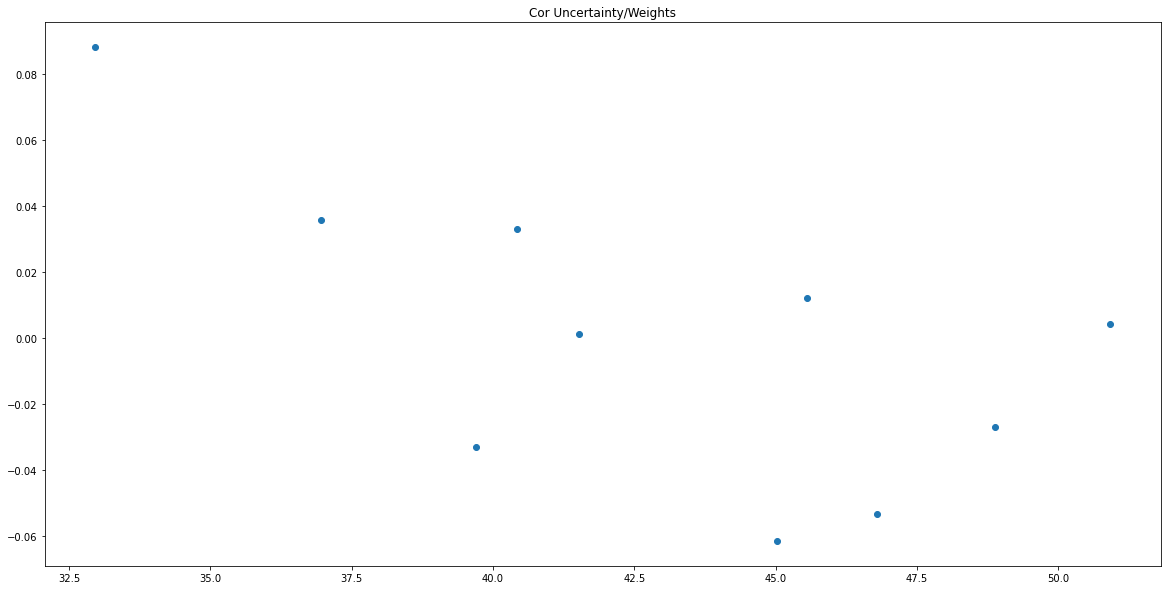

In [109]:
for i, tnsr in enumerate(Hessian):
    for j, (name, param) in enumerate(CIFAR10_model.named_parameters()):
        if i == j :
            print('layer index: {}'.format(i))
            print('layer name: {}'.format(name))
            print(param.size(), tnsr.size())
            conv2_weights_flattened = torch.flatten(param)
            conv2_uncertainties_flattened = torch.flatten(tnsr)
            plt.scatter(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
            plt.title('Cor Uncertainty/Weights')
            #print(np.cov(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy()))
            corr, _ = pearsonr(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
            print()
            print('Pearsons correlation: %.3f' % corr)
            plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  del sys.path[0]


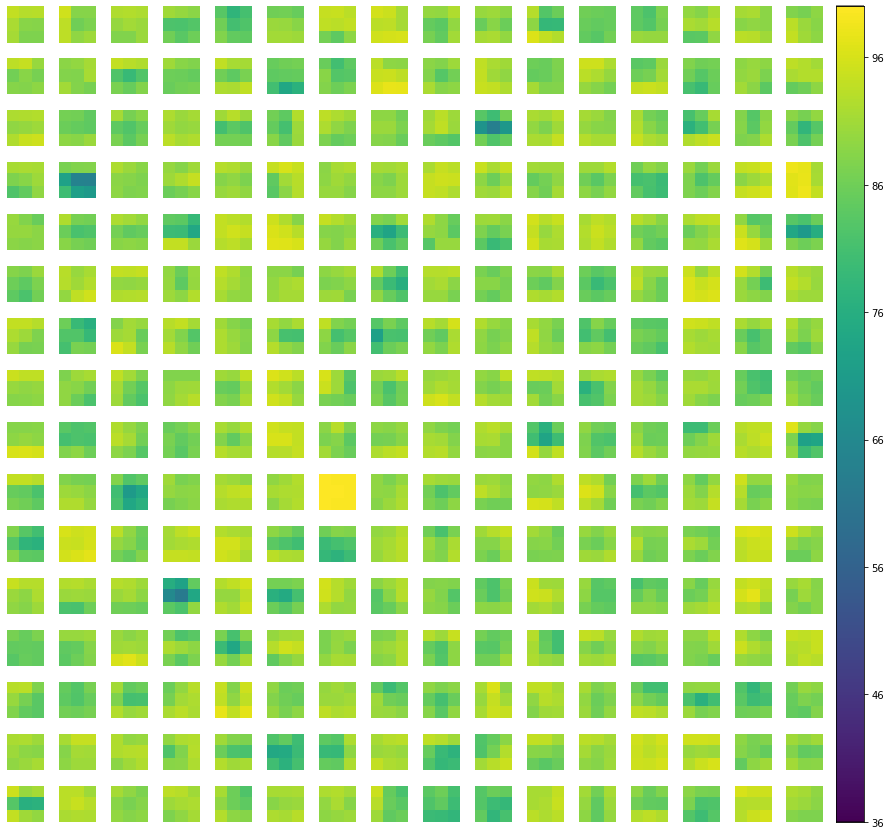

In [110]:
fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(16, 16), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)
min_val = np.floor(min(list(torch.flatten(Hessian[6]))))
max_val = np.ceil(max(list(torch.flatten(Hessian[6]))))
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(Hessian[6][i][0], vmin=min_val, vmax=max_val)
    #ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 10))
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  del sys.path[0]


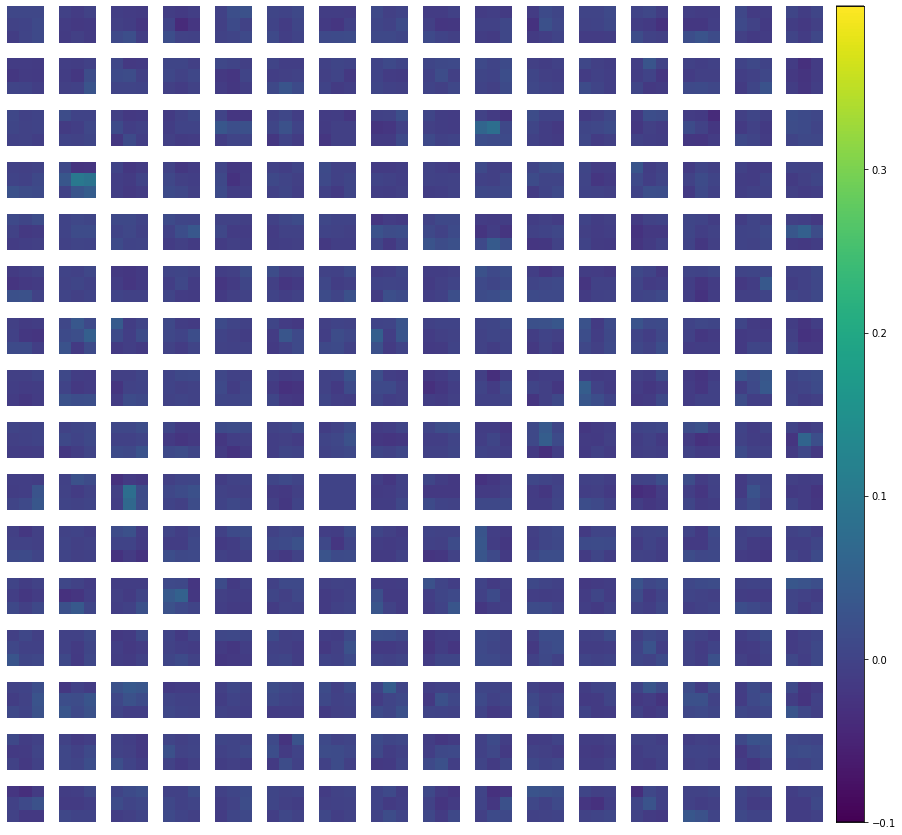

In [111]:
fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(16, 16), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)
min_val = np.round(min(list(torch.flatten(state['8.weight']))), 1)
max_val = np.round(max(list(torch.flatten(state['8.weight']))), 1)
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(state['8.weight'][i][0], vmin=min_val, vmax=max_val)
    #ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 0.10))
plt.show()

In [112]:
print(len(Hessian[2]))#[i]))#[0]))

128


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  del sys.path[0]


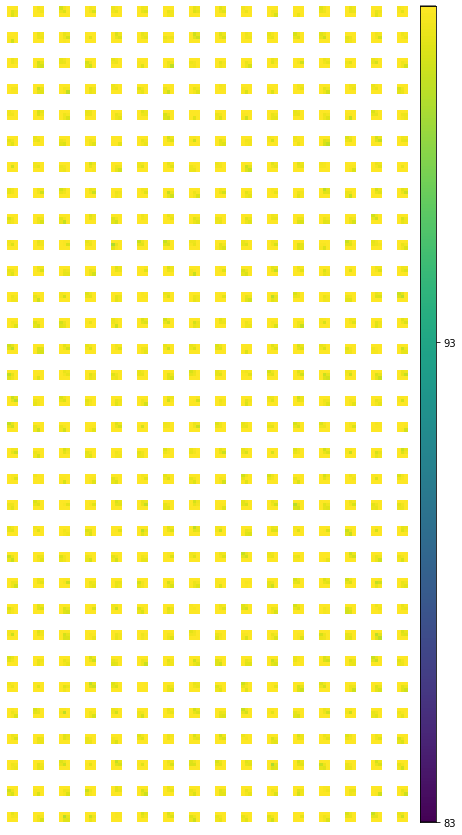

In [119]:
fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(32, 16), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)
min_val = np.floor(min(list(torch.flatten(Hessian[14]))))
max_val = np.ceil(max(list(torch.flatten(Hessian[14]))))
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(Hessian[14][i][0], vmin=min_val, vmax=max_val)
    #ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 10))
plt.show()